# Ensemble Classifier

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
import collections
import pickle
import os

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, plot_precision_recall_curve, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from xgboost import XGBClassifier

%matplotlib inline

In [2]:
data = {}
for dataset in os.listdir('../data/preprocessed'):
    with open(f'../data/preprocessed/{dataset}', 'rb') as fp:
        data[dataset[:-4]] = pickle.load(fp)
        
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

In [3]:
models = {}
for model in os.listdir('../models'):
    with open(f'../models/{model}', 'rb') as fp:
        models[model[:-4]] = pickle.load(fp)

In [4]:
for model in models:
    print(f'{model}:\t{recall_score(y_test, models[model].predict(X_test))}')

svcp:	0.8571428571428571
svcs:	0.8571428571428571
ab:	0.8571428571428571
lr:	0.8857142857142857
svcrbf:	0.8857142857142857
rf:	0.8571428571428571
knn:	0.8285714285714286
dt:	0.8571428571428571
xgb:	0.8285714285714286
svcl:	0.8857142857142857


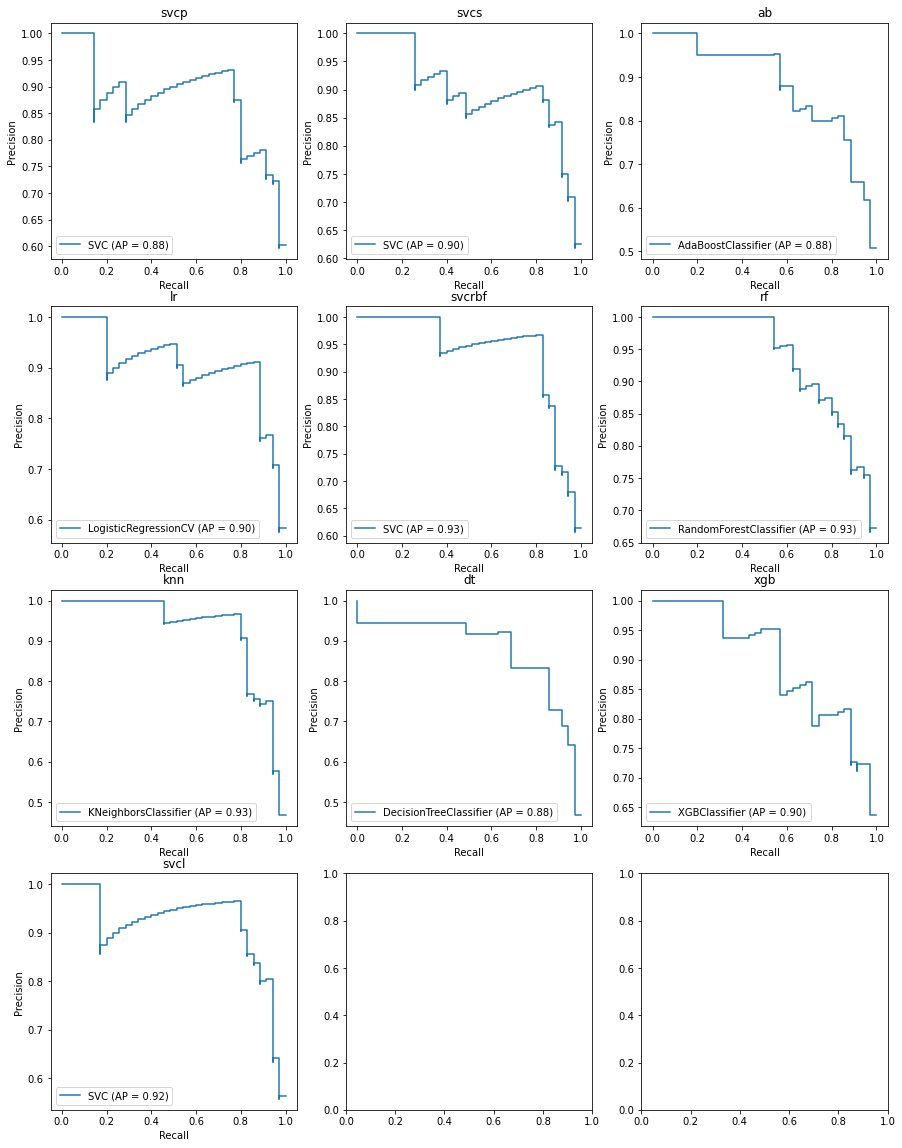

In [58]:
fig, axes = plt.subplots(4,3, figsize=(15,20))
for i, model in enumerate(models):
    plot_precision_recall_curve(models[model], X_test, y_test, ax=axes[i//3][i%3])
    axes[i//3][i%3].set_title(model)
    

Here I selected the three top performing models: the sigmoid kernel from the SVCs, AdaBoost from the boosters, and the decision tree over the random forest, for a total of **3 individual models**. I combined them into a single voting classifier below.

In [19]:
clf_votehard = VotingClassifier(
    estimators=[(model, models[model]) for model in models],
    voting='hard')
clf_votehard.fit(X_train, y_train)
recall_score(y_test, clf_votehard.predict(X_test))

0.8571428571428571

In [21]:
confusion_matrix(y_test, clf_votehard.predict(X_test))

array([[33,  7],
       [ 5, 30]])

This ensemble method does as well as two of the individual models, the decision tree and AdaBoost, but not as well the sigmoid SVC. I tried the same model, but with a soft voting system, giving a little more weight to the sigmoid SVC as it performed best on its own. I also included the KNN model hoping the extra diversity in models might produce a more powerful ensemble.

In [28]:
weight_values = [1,2]
import itertools
weight_perms = list(itertools.product(weight_values, repeat=len(models)))

In [29]:
param_grid = {
#     'ab__base_estimator': [DecisionTreeClassifier(max_depth=1), LogisticRegression(solver='lbfgs', multi_class='auto')], 
#     'ab__n_estimators': [10, 30, 50, 1000], 
#     'ab__learning_rate': [.0001, .001, .01, .1],
#     'svcl__kernel': ['linear'], 
#     'svcl__C': np.linspace(.1, 1, 10), 
#     'svcl__gamma': ['scale', 'auto'],
    'weights': weight_perms

}
gs_hard = GridSearchCV(clf_votehard, param_grid, scoring='recall', cv=5, verbose=2)
gs_hard.fit(X_train, y_train)

print(f'Train Recall: {gs_hard.best_score_}')
print(f'Test Recall: {recall_score(y_test, gs_hard.predict(X_test))}')
print(f'Train Accuracy: {accuracy_score(y_train, gs_hard.predict(X_train))}')
print(f'Test Accuracy: {accuracy_score(y_test, gs_hard.predict(X_test))}')
print(gs_hard.best_params_)

Fitting 5 folds for each of 1024 candidates, totalling 5120 fits
[CV] weights=(1, 1, 1, 1, 1, 1, 1, 1, 1, 1) ..........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........... weights=(1, 1, 1, 1, 1, 1, 1, 1, 1, 1), total=   0.4s
[CV] weights=(1, 1, 1, 1, 1, 1, 1, 1, 1, 1) ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ........... weights=(1, 1, 1, 1, 1, 1, 1, 1, 1, 1), total=   0.5s
[CV] weights=(1, 1, 1, 1, 1, 1, 1, 1, 1, 1) ..........................
[CV] ........... weights=(1, 1, 1, 1, 1, 1, 1, 1, 1, 1), total=   0.4s
[CV] weights=(1, 1, 1, 1, 1, 1, 1, 1, 1, 1) ..........................
[CV] ........... weights=(1, 1, 1, 1, 1, 1, 1, 1, 1, 1), total=   0.4s
[CV] weights=(1, 1, 1, 1, 1, 1, 1, 1, 1, 1) ..........................
[CV] ........... weights=(1, 1, 1, 1, 1, 1, 1, 1, 1, 1), total=   0.3s
[CV] weights=(1, 1, 1, 1, 1, 1, 1, 1, 1, 2) ..........................
[CV] ........... weights=(1, 1, 1, 1, 1, 1, 1, 1, 1, 2), total=   0.4s
[CV] weights=(1, 1, 1, 1, 1, 1, 1, 1, 1, 2) ..........................
[CV] ........... weights=(1, 1, 1, 1, 1, 1, 1, 1, 1, 2), total=   0.5s
[CV] weights=(1, 1, 1, 1, 1, 1, 1, 1, 1, 2) ..........................
[CV] ........... weights=(1, 1, 1, 1, 1, 1, 1, 1, 1, 2), total=   0.5s
[CV] weights=(1, 1, 1, 1, 1, 1, 1, 1, 1, 2) ..........................
[CV] .

[CV] ........... weights=(1, 1, 1, 1, 1, 1, 2, 1, 2, 2), total=   0.3s
[CV] weights=(1, 1, 1, 1, 1, 1, 2, 2, 1, 1) ..........................
[CV] ........... weights=(1, 1, 1, 1, 1, 1, 2, 2, 1, 1), total=   0.3s
[CV] weights=(1, 1, 1, 1, 1, 1, 2, 2, 1, 1) ..........................
[CV] ........... weights=(1, 1, 1, 1, 1, 1, 2, 2, 1, 1), total=   0.3s
[CV] weights=(1, 1, 1, 1, 1, 1, 2, 2, 1, 1) ..........................
[CV] ........... weights=(1, 1, 1, 1, 1, 1, 2, 2, 1, 1), total=   0.3s
[CV] weights=(1, 1, 1, 1, 1, 1, 2, 2, 1, 1) ..........................
[CV] ........... weights=(1, 1, 1, 1, 1, 1, 2, 2, 1, 1), total=   0.3s
[CV] weights=(1, 1, 1, 1, 1, 1, 2, 2, 1, 1) ..........................
[CV] ........... weights=(1, 1, 1, 1, 1, 1, 2, 2, 1, 1), total=   0.3s
[CV] weights=(1, 1, 1, 1, 1, 1, 2, 2, 1, 2) ..........................
[CV] ........... weights=(1, 1, 1, 1, 1, 1, 2, 2, 1, 2), total=   0.3s
[CV] weights=(1, 1, 1, 1, 1, 1, 2, 2, 1, 2) ..........................
[CV] .

[CV] ........... weights=(1, 1, 1, 1, 1, 2, 1, 2, 2, 2), total=   0.4s
[CV] weights=(1, 1, 1, 1, 1, 2, 1, 2, 2, 2) ..........................
[CV] ........... weights=(1, 1, 1, 1, 1, 2, 1, 2, 2, 2), total=   0.4s
[CV] weights=(1, 1, 1, 1, 1, 2, 1, 2, 2, 2) ..........................
[CV] ........... weights=(1, 1, 1, 1, 1, 2, 1, 2, 2, 2), total=   0.4s
[CV] weights=(1, 1, 1, 1, 1, 2, 2, 1, 1, 1) ..........................
[CV] ........... weights=(1, 1, 1, 1, 1, 2, 2, 1, 1, 1), total=   0.4s
[CV] weights=(1, 1, 1, 1, 1, 2, 2, 1, 1, 1) ..........................
[CV] ........... weights=(1, 1, 1, 1, 1, 2, 2, 1, 1, 1), total=   0.5s
[CV] weights=(1, 1, 1, 1, 1, 2, 2, 1, 1, 1) ..........................
[CV] ........... weights=(1, 1, 1, 1, 1, 2, 2, 1, 1, 1), total=   0.4s
[CV] weights=(1, 1, 1, 1, 1, 2, 2, 1, 1, 1) ..........................
[CV] ........... weights=(1, 1, 1, 1, 1, 2, 2, 1, 1, 1), total=   0.3s
[CV] weights=(1, 1, 1, 1, 1, 2, 2, 1, 1, 1) ..........................
[CV] .

[CV] ........... weights=(1, 1, 1, 1, 2, 1, 1, 1, 2, 2), total=   0.6s
[CV] weights=(1, 1, 1, 1, 2, 1, 1, 1, 2, 2) ..........................
[CV] ........... weights=(1, 1, 1, 1, 2, 1, 1, 1, 2, 2), total=   0.3s
[CV] weights=(1, 1, 1, 1, 2, 1, 1, 1, 2, 2) ..........................
[CV] ........... weights=(1, 1, 1, 1, 2, 1, 1, 1, 2, 2), total=   0.4s
[CV] weights=(1, 1, 1, 1, 2, 1, 1, 1, 2, 2) ..........................
[CV] ........... weights=(1, 1, 1, 1, 2, 1, 1, 1, 2, 2), total=   0.3s
[CV] weights=(1, 1, 1, 1, 2, 1, 1, 1, 2, 2) ..........................
[CV] ........... weights=(1, 1, 1, 1, 2, 1, 1, 1, 2, 2), total=   0.3s
[CV] weights=(1, 1, 1, 1, 2, 1, 1, 2, 1, 1) ..........................
[CV] ........... weights=(1, 1, 1, 1, 2, 1, 1, 2, 1, 1), total=   0.3s
[CV] weights=(1, 1, 1, 1, 2, 1, 1, 2, 1, 1) ..........................
[CV] ........... weights=(1, 1, 1, 1, 2, 1, 1, 2, 1, 1), total=   0.3s
[CV] weights=(1, 1, 1, 1, 2, 1, 1, 2, 1, 1) ..........................
[CV] .

[CV] ........... weights=(1, 1, 1, 1, 2, 1, 2, 2, 2, 1), total=   0.4s
[CV] weights=(1, 1, 1, 1, 2, 1, 2, 2, 2, 1) ..........................
[CV] ........... weights=(1, 1, 1, 1, 2, 1, 2, 2, 2, 1), total=   0.5s
[CV] weights=(1, 1, 1, 1, 2, 1, 2, 2, 2, 2) ..........................
[CV] ........... weights=(1, 1, 1, 1, 2, 1, 2, 2, 2, 2), total=   0.5s
[CV] weights=(1, 1, 1, 1, 2, 1, 2, 2, 2, 2) ..........................
[CV] ........... weights=(1, 1, 1, 1, 2, 1, 2, 2, 2, 2), total=   0.4s
[CV] weights=(1, 1, 1, 1, 2, 1, 2, 2, 2, 2) ..........................
[CV] ........... weights=(1, 1, 1, 1, 2, 1, 2, 2, 2, 2), total=   0.4s
[CV] weights=(1, 1, 1, 1, 2, 1, 2, 2, 2, 2) ..........................
[CV] ........... weights=(1, 1, 1, 1, 2, 1, 2, 2, 2, 2), total=   0.3s
[CV] weights=(1, 1, 1, 1, 2, 1, 2, 2, 2, 2) ..........................
[CV] ........... weights=(1, 1, 1, 1, 2, 1, 2, 2, 2, 2), total=   0.4s
[CV] weights=(1, 1, 1, 1, 2, 2, 1, 1, 1, 1) ..........................
[CV] .

[CV] ........... weights=(1, 1, 1, 1, 2, 2, 2, 1, 2, 1), total=   0.4s
[CV] weights=(1, 1, 1, 1, 2, 2, 2, 1, 2, 1) ..........................
[CV] ........... weights=(1, 1, 1, 1, 2, 2, 2, 1, 2, 1), total=   0.9s
[CV] weights=(1, 1, 1, 1, 2, 2, 2, 1, 2, 1) ..........................
[CV] ........... weights=(1, 1, 1, 1, 2, 2, 2, 1, 2, 1), total=   0.4s
[CV] weights=(1, 1, 1, 1, 2, 2, 2, 1, 2, 1) ..........................
[CV] ........... weights=(1, 1, 1, 1, 2, 2, 2, 1, 2, 1), total=   0.5s
[CV] weights=(1, 1, 1, 1, 2, 2, 2, 1, 2, 2) ..........................
[CV] ........... weights=(1, 1, 1, 1, 2, 2, 2, 1, 2, 2), total=   0.5s
[CV] weights=(1, 1, 1, 1, 2, 2, 2, 1, 2, 2) ..........................
[CV] ........... weights=(1, 1, 1, 1, 2, 2, 2, 1, 2, 2), total=   0.6s
[CV] weights=(1, 1, 1, 1, 2, 2, 2, 1, 2, 2) ..........................
[CV] ........... weights=(1, 1, 1, 1, 2, 2, 2, 1, 2, 2), total=   0.4s
[CV] weights=(1, 1, 1, 1, 2, 2, 2, 1, 2, 2) ..........................
[CV] .

[CV] ........... weights=(1, 1, 1, 2, 1, 1, 1, 2, 1, 2), total=   0.4s
[CV] weights=(1, 1, 1, 2, 1, 1, 1, 2, 2, 1) ..........................
[CV] ........... weights=(1, 1, 1, 2, 1, 1, 1, 2, 2, 1), total=   0.4s
[CV] weights=(1, 1, 1, 2, 1, 1, 1, 2, 2, 1) ..........................
[CV] ........... weights=(1, 1, 1, 2, 1, 1, 1, 2, 2, 1), total=   0.4s
[CV] weights=(1, 1, 1, 2, 1, 1, 1, 2, 2, 1) ..........................
[CV] ........... weights=(1, 1, 1, 2, 1, 1, 1, 2, 2, 1), total=   0.4s
[CV] weights=(1, 1, 1, 2, 1, 1, 1, 2, 2, 1) ..........................
[CV] ........... weights=(1, 1, 1, 2, 1, 1, 1, 2, 2, 1), total=   0.4s
[CV] weights=(1, 1, 1, 2, 1, 1, 1, 2, 2, 1) ..........................
[CV] ........... weights=(1, 1, 1, 2, 1, 1, 1, 2, 2, 1), total=   0.4s
[CV] weights=(1, 1, 1, 2, 1, 1, 1, 2, 2, 2) ..........................
[CV] ........... weights=(1, 1, 1, 2, 1, 1, 1, 2, 2, 2), total=   0.4s
[CV] weights=(1, 1, 1, 2, 1, 1, 1, 2, 2, 2) ..........................
[CV] .

[CV] ........... weights=(1, 1, 1, 2, 1, 2, 1, 1, 1, 2), total=   0.7s
[CV] weights=(1, 1, 1, 2, 1, 2, 1, 1, 1, 2) ..........................
[CV] ........... weights=(1, 1, 1, 2, 1, 2, 1, 1, 1, 2), total=   0.9s
[CV] weights=(1, 1, 1, 2, 1, 2, 1, 1, 1, 2) ..........................
[CV] ........... weights=(1, 1, 1, 2, 1, 2, 1, 1, 1, 2), total=   1.0s
[CV] weights=(1, 1, 1, 2, 1, 2, 1, 1, 2, 1) ..........................
[CV] ........... weights=(1, 1, 1, 2, 1, 2, 1, 1, 2, 1), total=   0.9s
[CV] weights=(1, 1, 1, 2, 1, 2, 1, 1, 2, 1) ..........................
[CV] ........... weights=(1, 1, 1, 2, 1, 2, 1, 1, 2, 1), total=   1.3s
[CV] weights=(1, 1, 1, 2, 1, 2, 1, 1, 2, 1) ..........................
[CV] ........... weights=(1, 1, 1, 2, 1, 2, 1, 1, 2, 1), total=   0.8s
[CV] weights=(1, 1, 1, 2, 1, 2, 1, 1, 2, 1) ..........................
[CV] ........... weights=(1, 1, 1, 2, 1, 2, 1, 1, 2, 1), total=   0.9s
[CV] weights=(1, 1, 1, 2, 1, 2, 1, 1, 2, 1) ..........................
[CV] .

[CV] ........... weights=(1, 1, 1, 2, 1, 2, 2, 2, 1, 2), total=   0.3s
[CV] weights=(1, 1, 1, 2, 1, 2, 2, 2, 1, 2) ..........................
[CV] ........... weights=(1, 1, 1, 2, 1, 2, 2, 2, 1, 2), total=   0.3s
[CV] weights=(1, 1, 1, 2, 1, 2, 2, 2, 1, 2) ..........................
[CV] ........... weights=(1, 1, 1, 2, 1, 2, 2, 2, 1, 2), total=   0.3s
[CV] weights=(1, 1, 1, 2, 1, 2, 2, 2, 1, 2) ..........................
[CV] ........... weights=(1, 1, 1, 2, 1, 2, 2, 2, 1, 2), total=   0.3s
[CV] weights=(1, 1, 1, 2, 1, 2, 2, 2, 1, 2) ..........................
[CV] ........... weights=(1, 1, 1, 2, 1, 2, 2, 2, 1, 2), total=   0.3s
[CV] weights=(1, 1, 1, 2, 1, 2, 2, 2, 2, 1) ..........................
[CV] ........... weights=(1, 1, 1, 2, 1, 2, 2, 2, 2, 1), total=   0.3s
[CV] weights=(1, 1, 1, 2, 1, 2, 2, 2, 2, 1) ..........................
[CV] ........... weights=(1, 1, 1, 2, 1, 2, 2, 2, 2, 1), total=   0.3s
[CV] weights=(1, 1, 1, 2, 1, 2, 2, 2, 2, 1) ..........................
[CV] .

[CV] ........... weights=(1, 1, 1, 2, 2, 1, 2, 1, 1, 1), total=   0.4s
[CV] weights=(1, 1, 1, 2, 2, 1, 2, 1, 1, 1) ..........................
[CV] ........... weights=(1, 1, 1, 2, 2, 1, 2, 1, 1, 1), total=   0.6s
[CV] weights=(1, 1, 1, 2, 2, 1, 2, 1, 1, 2) ..........................
[CV] ........... weights=(1, 1, 1, 2, 2, 1, 2, 1, 1, 2), total=   0.6s
[CV] weights=(1, 1, 1, 2, 2, 1, 2, 1, 1, 2) ..........................
[CV] ........... weights=(1, 1, 1, 2, 2, 1, 2, 1, 1, 2), total=   0.6s
[CV] weights=(1, 1, 1, 2, 2, 1, 2, 1, 1, 2) ..........................
[CV] ........... weights=(1, 1, 1, 2, 2, 1, 2, 1, 1, 2), total=   0.4s
[CV] weights=(1, 1, 1, 2, 2, 1, 2, 1, 1, 2) ..........................
[CV] ........... weights=(1, 1, 1, 2, 2, 1, 2, 1, 1, 2), total=   0.4s
[CV] weights=(1, 1, 1, 2, 2, 1, 2, 1, 1, 2) ..........................
[CV] ........... weights=(1, 1, 1, 2, 2, 1, 2, 1, 1, 2), total=   0.6s
[CV] weights=(1, 1, 1, 2, 2, 1, 2, 1, 2, 1) ..........................
[CV] .

[CV] ........... weights=(1, 1, 1, 2, 2, 2, 1, 2, 1, 1), total=   0.3s
[CV] weights=(1, 1, 1, 2, 2, 2, 1, 2, 1, 1) ..........................
[CV] ........... weights=(1, 1, 1, 2, 2, 2, 1, 2, 1, 1), total=   0.5s
[CV] weights=(1, 1, 1, 2, 2, 2, 1, 2, 1, 1) ..........................
[CV] ........... weights=(1, 1, 1, 2, 2, 2, 1, 2, 1, 1), total=   0.4s
[CV] weights=(1, 1, 1, 2, 2, 2, 1, 2, 1, 1) ..........................
[CV] ........... weights=(1, 1, 1, 2, 2, 2, 1, 2, 1, 1), total=   0.6s
[CV] weights=(1, 1, 1, 2, 2, 2, 1, 2, 1, 2) ..........................
[CV] ........... weights=(1, 1, 1, 2, 2, 2, 1, 2, 1, 2), total=   0.6s
[CV] weights=(1, 1, 1, 2, 2, 2, 1, 2, 1, 2) ..........................
[CV] ........... weights=(1, 1, 1, 2, 2, 2, 1, 2, 1, 2), total=   0.4s
[CV] weights=(1, 1, 1, 2, 2, 2, 1, 2, 1, 2) ..........................
[CV] ........... weights=(1, 1, 1, 2, 2, 2, 1, 2, 1, 2), total=   0.8s
[CV] weights=(1, 1, 1, 2, 2, 2, 1, 2, 1, 2) ..........................
[CV] .

[CV] ........... weights=(1, 1, 1, 2, 2, 2, 2, 2, 2, 2), total=   0.3s
[CV] weights=(1, 1, 2, 1, 1, 1, 1, 1, 1, 1) ..........................
[CV] ........... weights=(1, 1, 2, 1, 1, 1, 1, 1, 1, 1), total=   0.3s
[CV] weights=(1, 1, 2, 1, 1, 1, 1, 1, 1, 1) ..........................
[CV] ........... weights=(1, 1, 2, 1, 1, 1, 1, 1, 1, 1), total=   0.3s
[CV] weights=(1, 1, 2, 1, 1, 1, 1, 1, 1, 1) ..........................
[CV] ........... weights=(1, 1, 2, 1, 1, 1, 1, 1, 1, 1), total=   0.3s
[CV] weights=(1, 1, 2, 1, 1, 1, 1, 1, 1, 1) ..........................
[CV] ........... weights=(1, 1, 2, 1, 1, 1, 1, 1, 1, 1), total=   0.4s
[CV] weights=(1, 1, 2, 1, 1, 1, 1, 1, 1, 1) ..........................
[CV] ........... weights=(1, 1, 2, 1, 1, 1, 1, 1, 1, 1), total=   0.4s
[CV] weights=(1, 1, 2, 1, 1, 1, 1, 1, 1, 2) ..........................
[CV] ........... weights=(1, 1, 2, 1, 1, 1, 1, 1, 1, 2), total=   0.3s
[CV] weights=(1, 1, 2, 1, 1, 1, 1, 1, 1, 2) ..........................
[CV] .

[CV] ........... weights=(1, 1, 2, 1, 1, 1, 2, 1, 2, 2), total=   0.4s
[CV] weights=(1, 1, 2, 1, 1, 1, 2, 1, 2, 2) ..........................
[CV] ........... weights=(1, 1, 2, 1, 1, 1, 2, 1, 2, 2), total=   0.3s
[CV] weights=(1, 1, 2, 1, 1, 1, 2, 1, 2, 2) ..........................
[CV] ........... weights=(1, 1, 2, 1, 1, 1, 2, 1, 2, 2), total=   0.5s
[CV] weights=(1, 1, 2, 1, 1, 1, 2, 2, 1, 1) ..........................
[CV] ........... weights=(1, 1, 2, 1, 1, 1, 2, 2, 1, 1), total=   0.3s
[CV] weights=(1, 1, 2, 1, 1, 1, 2, 2, 1, 1) ..........................
[CV] ........... weights=(1, 1, 2, 1, 1, 1, 2, 2, 1, 1), total=   0.5s
[CV] weights=(1, 1, 2, 1, 1, 1, 2, 2, 1, 1) ..........................
[CV] ........... weights=(1, 1, 2, 1, 1, 1, 2, 2, 1, 1), total=   0.3s
[CV] weights=(1, 1, 2, 1, 1, 1, 2, 2, 1, 1) ..........................
[CV] ........... weights=(1, 1, 2, 1, 1, 1, 2, 2, 1, 1), total=   0.4s
[CV] weights=(1, 1, 2, 1, 1, 1, 2, 2, 1, 1) ..........................
[CV] .

[CV] ........... weights=(1, 1, 2, 1, 1, 2, 1, 2, 2, 2), total=   0.4s
[CV] weights=(1, 1, 2, 1, 1, 2, 1, 2, 2, 2) ..........................
[CV] ........... weights=(1, 1, 2, 1, 1, 2, 1, 2, 2, 2), total=   0.4s
[CV] weights=(1, 1, 2, 1, 1, 2, 1, 2, 2, 2) ..........................
[CV] ........... weights=(1, 1, 2, 1, 1, 2, 1, 2, 2, 2), total=   0.5s
[CV] weights=(1, 1, 2, 1, 1, 2, 1, 2, 2, 2) ..........................
[CV] ........... weights=(1, 1, 2, 1, 1, 2, 1, 2, 2, 2), total=   0.3s
[CV] weights=(1, 1, 2, 1, 1, 2, 1, 2, 2, 2) ..........................
[CV] ........... weights=(1, 1, 2, 1, 1, 2, 1, 2, 2, 2), total=   0.4s
[CV] weights=(1, 1, 2, 1, 1, 2, 2, 1, 1, 1) ..........................
[CV] ........... weights=(1, 1, 2, 1, 1, 2, 2, 1, 1, 1), total=   0.4s
[CV] weights=(1, 1, 2, 1, 1, 2, 2, 1, 1, 1) ..........................
[CV] ........... weights=(1, 1, 2, 1, 1, 2, 2, 1, 1, 1), total=   0.3s
[CV] weights=(1, 1, 2, 1, 1, 2, 2, 1, 1, 1) ..........................
[CV] .

[CV] ........... weights=(1, 1, 2, 1, 2, 1, 1, 1, 2, 1), total=   1.1s
[CV] weights=(1, 1, 2, 1, 2, 1, 1, 1, 2, 1) ..........................
[CV] ........... weights=(1, 1, 2, 1, 2, 1, 1, 1, 2, 1), total=   1.0s
[CV] weights=(1, 1, 2, 1, 2, 1, 1, 1, 2, 2) ..........................
[CV] ........... weights=(1, 1, 2, 1, 2, 1, 1, 1, 2, 2), total=   0.9s
[CV] weights=(1, 1, 2, 1, 2, 1, 1, 1, 2, 2) ..........................
[CV] ........... weights=(1, 1, 2, 1, 2, 1, 1, 1, 2, 2), total=   0.9s
[CV] weights=(1, 1, 2, 1, 2, 1, 1, 1, 2, 2) ..........................
[CV] ........... weights=(1, 1, 2, 1, 2, 1, 1, 1, 2, 2), total=   0.8s
[CV] weights=(1, 1, 2, 1, 2, 1, 1, 1, 2, 2) ..........................
[CV] ........... weights=(1, 1, 2, 1, 2, 1, 1, 1, 2, 2), total=   0.7s
[CV] weights=(1, 1, 2, 1, 2, 1, 1, 1, 2, 2) ..........................
[CV] ........... weights=(1, 1, 2, 1, 2, 1, 1, 1, 2, 2), total=   0.7s
[CV] weights=(1, 1, 2, 1, 2, 1, 1, 2, 1, 1) ..........................
[CV] .

[CV] ........... weights=(1, 1, 2, 1, 2, 1, 2, 2, 2, 1), total=   0.7s
[CV] weights=(1, 1, 2, 1, 2, 1, 2, 2, 2, 1) ..........................
[CV] ........... weights=(1, 1, 2, 1, 2, 1, 2, 2, 2, 1), total=   0.7s
[CV] weights=(1, 1, 2, 1, 2, 1, 2, 2, 2, 1) ..........................
[CV] ........... weights=(1, 1, 2, 1, 2, 1, 2, 2, 2, 1), total=   0.5s
[CV] weights=(1, 1, 2, 1, 2, 1, 2, 2, 2, 1) ..........................
[CV] ........... weights=(1, 1, 2, 1, 2, 1, 2, 2, 2, 1), total=   0.5s
[CV] weights=(1, 1, 2, 1, 2, 1, 2, 2, 2, 2) ..........................
[CV] ........... weights=(1, 1, 2, 1, 2, 1, 2, 2, 2, 2), total=   0.4s
[CV] weights=(1, 1, 2, 1, 2, 1, 2, 2, 2, 2) ..........................
[CV] ........... weights=(1, 1, 2, 1, 2, 1, 2, 2, 2, 2), total=   0.4s
[CV] weights=(1, 1, 2, 1, 2, 1, 2, 2, 2, 2) ..........................
[CV] ........... weights=(1, 1, 2, 1, 2, 1, 2, 2, 2, 2), total=   0.3s
[CV] weights=(1, 1, 2, 1, 2, 1, 2, 2, 2, 2) ..........................
[CV] .

[CV] ........... weights=(1, 1, 2, 1, 2, 2, 2, 1, 1, 2), total=   0.3s
[CV] weights=(1, 1, 2, 1, 2, 2, 2, 1, 2, 1) ..........................
[CV] ........... weights=(1, 1, 2, 1, 2, 2, 2, 1, 2, 1), total=   0.4s
[CV] weights=(1, 1, 2, 1, 2, 2, 2, 1, 2, 1) ..........................
[CV] ........... weights=(1, 1, 2, 1, 2, 2, 2, 1, 2, 1), total=   0.4s
[CV] weights=(1, 1, 2, 1, 2, 2, 2, 1, 2, 1) ..........................
[CV] ........... weights=(1, 1, 2, 1, 2, 2, 2, 1, 2, 1), total=   0.4s
[CV] weights=(1, 1, 2, 1, 2, 2, 2, 1, 2, 1) ..........................
[CV] ........... weights=(1, 1, 2, 1, 2, 2, 2, 1, 2, 1), total=   0.5s
[CV] weights=(1, 1, 2, 1, 2, 2, 2, 1, 2, 1) ..........................
[CV] ........... weights=(1, 1, 2, 1, 2, 2, 2, 1, 2, 1), total=   0.6s
[CV] weights=(1, 1, 2, 1, 2, 2, 2, 1, 2, 2) ..........................
[CV] ........... weights=(1, 1, 2, 1, 2, 2, 2, 1, 2, 2), total=   0.7s
[CV] weights=(1, 1, 2, 1, 2, 2, 2, 1, 2, 2) ..........................
[CV] .

[CV] ........... weights=(1, 1, 2, 2, 1, 1, 1, 2, 1, 2), total=   0.5s
[CV] weights=(1, 1, 2, 2, 1, 1, 1, 2, 1, 2) ..........................
[CV] ........... weights=(1, 1, 2, 2, 1, 1, 1, 2, 1, 2), total=   0.4s
[CV] weights=(1, 1, 2, 2, 1, 1, 1, 2, 1, 2) ..........................
[CV] ........... weights=(1, 1, 2, 2, 1, 1, 1, 2, 1, 2), total=   0.4s
[CV] weights=(1, 1, 2, 2, 1, 1, 1, 2, 2, 1) ..........................
[CV] ........... weights=(1, 1, 2, 2, 1, 1, 1, 2, 2, 1), total=   0.5s
[CV] weights=(1, 1, 2, 2, 1, 1, 1, 2, 2, 1) ..........................
[CV] ........... weights=(1, 1, 2, 2, 1, 1, 1, 2, 2, 1), total=   0.5s
[CV] weights=(1, 1, 2, 2, 1, 1, 1, 2, 2, 1) ..........................
[CV] ........... weights=(1, 1, 2, 2, 1, 1, 1, 2, 2, 1), total=   0.4s
[CV] weights=(1, 1, 2, 2, 1, 1, 1, 2, 2, 1) ..........................
[CV] ........... weights=(1, 1, 2, 2, 1, 1, 1, 2, 2, 1), total=   0.4s
[CV] weights=(1, 1, 2, 2, 1, 1, 1, 2, 2, 1) ..........................
[CV] .

[CV] ........... weights=(1, 1, 2, 2, 1, 2, 1, 1, 1, 2), total=   0.6s
[CV] weights=(1, 1, 2, 2, 1, 2, 1, 1, 1, 2) ..........................
[CV] ........... weights=(1, 1, 2, 2, 1, 2, 1, 1, 1, 2), total=   0.4s
[CV] weights=(1, 1, 2, 2, 1, 2, 1, 1, 1, 2) ..........................
[CV] ........... weights=(1, 1, 2, 2, 1, 2, 1, 1, 1, 2), total=   0.6s
[CV] weights=(1, 1, 2, 2, 1, 2, 1, 1, 1, 2) ..........................
[CV] ........... weights=(1, 1, 2, 2, 1, 2, 1, 1, 1, 2), total=   0.4s
[CV] weights=(1, 1, 2, 2, 1, 2, 1, 1, 1, 2) ..........................
[CV] ........... weights=(1, 1, 2, 2, 1, 2, 1, 1, 1, 2), total=   1.3s
[CV] weights=(1, 1, 2, 2, 1, 2, 1, 1, 2, 1) ..........................
[CV] ........... weights=(1, 1, 2, 2, 1, 2, 1, 1, 2, 1), total=   0.5s
[CV] weights=(1, 1, 2, 2, 1, 2, 1, 1, 2, 1) ..........................
[CV] ........... weights=(1, 1, 2, 2, 1, 2, 1, 1, 2, 1), total=   0.4s
[CV] weights=(1, 1, 2, 2, 1, 2, 1, 1, 2, 1) ..........................
[CV] .

[CV] ........... weights=(1, 1, 2, 2, 1, 2, 2, 2, 1, 1), total=   0.4s
[CV] weights=(1, 1, 2, 2, 1, 2, 2, 2, 1, 1) ..........................
[CV] ........... weights=(1, 1, 2, 2, 1, 2, 2, 2, 1, 1), total=   0.4s
[CV] weights=(1, 1, 2, 2, 1, 2, 2, 2, 1, 2) ..........................
[CV] ........... weights=(1, 1, 2, 2, 1, 2, 2, 2, 1, 2), total=   0.4s
[CV] weights=(1, 1, 2, 2, 1, 2, 2, 2, 1, 2) ..........................
[CV] ........... weights=(1, 1, 2, 2, 1, 2, 2, 2, 1, 2), total=   0.4s
[CV] weights=(1, 1, 2, 2, 1, 2, 2, 2, 1, 2) ..........................
[CV] ........... weights=(1, 1, 2, 2, 1, 2, 2, 2, 1, 2), total=   0.5s
[CV] weights=(1, 1, 2, 2, 1, 2, 2, 2, 1, 2) ..........................
[CV] ........... weights=(1, 1, 2, 2, 1, 2, 2, 2, 1, 2), total=   0.4s
[CV] weights=(1, 1, 2, 2, 1, 2, 2, 2, 1, 2) ..........................
[CV] ........... weights=(1, 1, 2, 2, 1, 2, 2, 2, 1, 2), total=   0.3s
[CV] weights=(1, 1, 2, 2, 1, 2, 2, 2, 2, 1) ..........................
[CV] .

[CV] ........... weights=(1, 1, 2, 2, 2, 1, 2, 1, 1, 1), total=   0.6s
[CV] weights=(1, 1, 2, 2, 2, 1, 2, 1, 1, 1) ..........................
[CV] ........... weights=(1, 1, 2, 2, 2, 1, 2, 1, 1, 1), total=   0.5s
[CV] weights=(1, 1, 2, 2, 2, 1, 2, 1, 1, 1) ..........................
[CV] ........... weights=(1, 1, 2, 2, 2, 1, 2, 1, 1, 1), total=   0.4s
[CV] weights=(1, 1, 2, 2, 2, 1, 2, 1, 1, 1) ..........................
[CV] ........... weights=(1, 1, 2, 2, 2, 1, 2, 1, 1, 1), total=   0.3s
[CV] weights=(1, 1, 2, 2, 2, 1, 2, 1, 1, 2) ..........................
[CV] ........... weights=(1, 1, 2, 2, 2, 1, 2, 1, 1, 2), total=   0.4s
[CV] weights=(1, 1, 2, 2, 2, 1, 2, 1, 1, 2) ..........................
[CV] ........... weights=(1, 1, 2, 2, 2, 1, 2, 1, 1, 2), total=   0.3s
[CV] weights=(1, 1, 2, 2, 2, 1, 2, 1, 1, 2) ..........................
[CV] ........... weights=(1, 1, 2, 2, 2, 1, 2, 1, 1, 2), total=   0.3s
[CV] weights=(1, 1, 2, 2, 2, 1, 2, 1, 1, 2) ..........................
[CV] .

[CV] ........... weights=(1, 1, 2, 2, 2, 2, 1, 1, 2, 2), total=   0.3s
[CV] weights=(1, 1, 2, 2, 2, 2, 1, 2, 1, 1) ..........................
[CV] ........... weights=(1, 1, 2, 2, 2, 2, 1, 2, 1, 1), total=   0.4s
[CV] weights=(1, 1, 2, 2, 2, 2, 1, 2, 1, 1) ..........................
[CV] ........... weights=(1, 1, 2, 2, 2, 2, 1, 2, 1, 1), total=   0.4s
[CV] weights=(1, 1, 2, 2, 2, 2, 1, 2, 1, 1) ..........................
[CV] ........... weights=(1, 1, 2, 2, 2, 2, 1, 2, 1, 1), total=   0.3s
[CV] weights=(1, 1, 2, 2, 2, 2, 1, 2, 1, 1) ..........................
[CV] ........... weights=(1, 1, 2, 2, 2, 2, 1, 2, 1, 1), total=   0.4s
[CV] weights=(1, 1, 2, 2, 2, 2, 1, 2, 1, 1) ..........................
[CV] ........... weights=(1, 1, 2, 2, 2, 2, 1, 2, 1, 1), total=   0.4s
[CV] weights=(1, 1, 2, 2, 2, 2, 1, 2, 1, 2) ..........................
[CV] ........... weights=(1, 1, 2, 2, 2, 2, 1, 2, 1, 2), total=   0.4s
[CV] weights=(1, 1, 2, 2, 2, 2, 1, 2, 1, 2) ..........................
[CV] .

[CV] ........... weights=(1, 1, 2, 2, 2, 2, 2, 2, 2, 2), total=   0.3s
[CV] weights=(1, 1, 2, 2, 2, 2, 2, 2, 2, 2) ..........................
[CV] ........... weights=(1, 1, 2, 2, 2, 2, 2, 2, 2, 2), total=   0.3s
[CV] weights=(1, 1, 2, 2, 2, 2, 2, 2, 2, 2) ..........................
[CV] ........... weights=(1, 1, 2, 2, 2, 2, 2, 2, 2, 2), total=   0.4s
[CV] weights=(1, 2, 1, 1, 1, 1, 1, 1, 1, 1) ..........................
[CV] ........... weights=(1, 2, 1, 1, 1, 1, 1, 1, 1, 1), total=   0.4s
[CV] weights=(1, 2, 1, 1, 1, 1, 1, 1, 1, 1) ..........................
[CV] ........... weights=(1, 2, 1, 1, 1, 1, 1, 1, 1, 1), total=   0.4s
[CV] weights=(1, 2, 1, 1, 1, 1, 1, 1, 1, 1) ..........................
[CV] ........... weights=(1, 2, 1, 1, 1, 1, 1, 1, 1, 1), total=   0.5s
[CV] weights=(1, 2, 1, 1, 1, 1, 1, 1, 1, 1) ..........................
[CV] ........... weights=(1, 2, 1, 1, 1, 1, 1, 1, 1, 1), total=   0.6s
[CV] weights=(1, 2, 1, 1, 1, 1, 1, 1, 1, 1) ..........................
[CV] .

[CV] ........... weights=(1, 2, 1, 1, 1, 1, 2, 1, 2, 2), total=   0.3s
[CV] weights=(1, 2, 1, 1, 1, 1, 2, 1, 2, 2) ..........................
[CV] ........... weights=(1, 2, 1, 1, 1, 1, 2, 1, 2, 2), total=   0.3s
[CV] weights=(1, 2, 1, 1, 1, 1, 2, 1, 2, 2) ..........................
[CV] ........... weights=(1, 2, 1, 1, 1, 1, 2, 1, 2, 2), total=   0.3s
[CV] weights=(1, 2, 1, 1, 1, 1, 2, 1, 2, 2) ..........................
[CV] ........... weights=(1, 2, 1, 1, 1, 1, 2, 1, 2, 2), total=   0.3s
[CV] weights=(1, 2, 1, 1, 1, 1, 2, 1, 2, 2) ..........................
[CV] ........... weights=(1, 2, 1, 1, 1, 1, 2, 1, 2, 2), total=   0.4s
[CV] weights=(1, 2, 1, 1, 1, 1, 2, 2, 1, 1) ..........................
[CV] ........... weights=(1, 2, 1, 1, 1, 1, 2, 2, 1, 1), total=   0.3s
[CV] weights=(1, 2, 1, 1, 1, 1, 2, 2, 1, 1) ..........................
[CV] ........... weights=(1, 2, 1, 1, 1, 1, 2, 2, 1, 1), total=   0.5s
[CV] weights=(1, 2, 1, 1, 1, 1, 2, 2, 1, 1) ..........................
[CV] .

[CV] ........... weights=(1, 2, 1, 1, 1, 2, 1, 2, 2, 1), total=   0.5s
[CV] weights=(1, 2, 1, 1, 1, 2, 1, 2, 2, 1) ..........................
[CV] ........... weights=(1, 2, 1, 1, 1, 2, 1, 2, 2, 1), total=   0.3s
[CV] weights=(1, 2, 1, 1, 1, 2, 1, 2, 2, 2) ..........................
[CV] ........... weights=(1, 2, 1, 1, 1, 2, 1, 2, 2, 2), total=   0.3s
[CV] weights=(1, 2, 1, 1, 1, 2, 1, 2, 2, 2) ..........................
[CV] ........... weights=(1, 2, 1, 1, 1, 2, 1, 2, 2, 2), total=   0.3s
[CV] weights=(1, 2, 1, 1, 1, 2, 1, 2, 2, 2) ..........................
[CV] ........... weights=(1, 2, 1, 1, 1, 2, 1, 2, 2, 2), total=   0.3s
[CV] weights=(1, 2, 1, 1, 1, 2, 1, 2, 2, 2) ..........................
[CV] ........... weights=(1, 2, 1, 1, 1, 2, 1, 2, 2, 2), total=   0.3s
[CV] weights=(1, 2, 1, 1, 1, 2, 1, 2, 2, 2) ..........................
[CV] ........... weights=(1, 2, 1, 1, 1, 2, 1, 2, 2, 2), total=   0.3s
[CV] weights=(1, 2, 1, 1, 1, 2, 2, 1, 1, 1) ..........................
[CV] .

[CV] ........... weights=(1, 2, 1, 1, 2, 1, 1, 1, 2, 1), total=   0.4s
[CV] weights=(1, 2, 1, 1, 2, 1, 1, 1, 2, 1) ..........................
[CV] ........... weights=(1, 2, 1, 1, 2, 1, 1, 1, 2, 1), total=   0.3s
[CV] weights=(1, 2, 1, 1, 2, 1, 1, 1, 2, 1) ..........................
[CV] ........... weights=(1, 2, 1, 1, 2, 1, 1, 1, 2, 1), total=   0.4s
[CV] weights=(1, 2, 1, 1, 2, 1, 1, 1, 2, 1) ..........................
[CV] ........... weights=(1, 2, 1, 1, 2, 1, 1, 1, 2, 1), total=   0.4s
[CV] weights=(1, 2, 1, 1, 2, 1, 1, 1, 2, 2) ..........................
[CV] ........... weights=(1, 2, 1, 1, 2, 1, 1, 1, 2, 2), total=   0.3s
[CV] weights=(1, 2, 1, 1, 2, 1, 1, 1, 2, 2) ..........................
[CV] ........... weights=(1, 2, 1, 1, 2, 1, 1, 1, 2, 2), total=   0.3s
[CV] weights=(1, 2, 1, 1, 2, 1, 1, 1, 2, 2) ..........................
[CV] ........... weights=(1, 2, 1, 1, 2, 1, 1, 1, 2, 2), total=   0.4s
[CV] weights=(1, 2, 1, 1, 2, 1, 1, 1, 2, 2) ..........................
[CV] .

[CV] ........... weights=(1, 2, 1, 1, 2, 1, 2, 2, 1, 2), total=   0.3s
[CV] weights=(1, 2, 1, 1, 2, 1, 2, 2, 2, 1) ..........................
[CV] ........... weights=(1, 2, 1, 1, 2, 1, 2, 2, 2, 1), total=   0.5s
[CV] weights=(1, 2, 1, 1, 2, 1, 2, 2, 2, 1) ..........................
[CV] ........... weights=(1, 2, 1, 1, 2, 1, 2, 2, 2, 1), total=   1.1s
[CV] weights=(1, 2, 1, 1, 2, 1, 2, 2, 2, 1) ..........................
[CV] ........... weights=(1, 2, 1, 1, 2, 1, 2, 2, 2, 1), total=   0.7s
[CV] weights=(1, 2, 1, 1, 2, 1, 2, 2, 2, 1) ..........................
[CV] ........... weights=(1, 2, 1, 1, 2, 1, 2, 2, 2, 1), total=   0.9s
[CV] weights=(1, 2, 1, 1, 2, 1, 2, 2, 2, 1) ..........................
[CV] ........... weights=(1, 2, 1, 1, 2, 1, 2, 2, 2, 1), total=   1.5s
[CV] weights=(1, 2, 1, 1, 2, 1, 2, 2, 2, 2) ..........................
[CV] ........... weights=(1, 2, 1, 1, 2, 1, 2, 2, 2, 2), total=   1.3s
[CV] weights=(1, 2, 1, 1, 2, 1, 2, 2, 2, 2) ..........................
[CV] .

[CV] ........... weights=(1, 2, 1, 1, 2, 2, 2, 1, 1, 2), total=   0.3s
[CV] weights=(1, 2, 1, 1, 2, 2, 2, 1, 1, 2) ..........................
[CV] ........... weights=(1, 2, 1, 1, 2, 2, 2, 1, 1, 2), total=   0.3s
[CV] weights=(1, 2, 1, 1, 2, 2, 2, 1, 1, 2) ..........................
[CV] ........... weights=(1, 2, 1, 1, 2, 2, 2, 1, 1, 2), total=   0.4s
[CV] weights=(1, 2, 1, 1, 2, 2, 2, 1, 2, 1) ..........................
[CV] ........... weights=(1, 2, 1, 1, 2, 2, 2, 1, 2, 1), total=   0.6s
[CV] weights=(1, 2, 1, 1, 2, 2, 2, 1, 2, 1) ..........................
[CV] ........... weights=(1, 2, 1, 1, 2, 2, 2, 1, 2, 1), total=   0.4s
[CV] weights=(1, 2, 1, 1, 2, 2, 2, 1, 2, 1) ..........................
[CV] ........... weights=(1, 2, 1, 1, 2, 2, 2, 1, 2, 1), total=   0.3s
[CV] weights=(1, 2, 1, 1, 2, 2, 2, 1, 2, 1) ..........................
[CV] ........... weights=(1, 2, 1, 1, 2, 2, 2, 1, 2, 1), total=   0.3s
[CV] weights=(1, 2, 1, 1, 2, 2, 2, 1, 2, 1) ..........................
[CV] .

[CV] ........... weights=(1, 2, 1, 2, 1, 1, 1, 2, 1, 2), total=   0.5s
[CV] weights=(1, 2, 1, 2, 1, 1, 1, 2, 1, 2) ..........................
[CV] ........... weights=(1, 2, 1, 2, 1, 1, 1, 2, 1, 2), total=   0.4s
[CV] weights=(1, 2, 1, 2, 1, 1, 1, 2, 1, 2) ..........................
[CV] ........... weights=(1, 2, 1, 2, 1, 1, 1, 2, 1, 2), total=   0.4s
[CV] weights=(1, 2, 1, 2, 1, 1, 1, 2, 1, 2) ..........................
[CV] ........... weights=(1, 2, 1, 2, 1, 1, 1, 2, 1, 2), total=   0.4s
[CV] weights=(1, 2, 1, 2, 1, 1, 1, 2, 1, 2) ..........................
[CV] ........... weights=(1, 2, 1, 2, 1, 1, 1, 2, 1, 2), total=   0.5s
[CV] weights=(1, 2, 1, 2, 1, 1, 1, 2, 2, 1) ..........................
[CV] ........... weights=(1, 2, 1, 2, 1, 1, 1, 2, 2, 1), total=   0.4s
[CV] weights=(1, 2, 1, 2, 1, 1, 1, 2, 2, 1) ..........................
[CV] ........... weights=(1, 2, 1, 2, 1, 1, 1, 2, 2, 1), total=   0.4s
[CV] weights=(1, 2, 1, 2, 1, 1, 1, 2, 2, 1) ..........................
[CV] .

[CV] ........... weights=(1, 2, 1, 2, 1, 2, 1, 1, 1, 1), total=   0.4s
[CV] weights=(1, 2, 1, 2, 1, 2, 1, 1, 1, 1) ..........................
[CV] ........... weights=(1, 2, 1, 2, 1, 2, 1, 1, 1, 1), total=   0.4s
[CV] weights=(1, 2, 1, 2, 1, 2, 1, 1, 1, 2) ..........................
[CV] ........... weights=(1, 2, 1, 2, 1, 2, 1, 1, 1, 2), total=   1.0s
[CV] weights=(1, 2, 1, 2, 1, 2, 1, 1, 1, 2) ..........................
[CV] ........... weights=(1, 2, 1, 2, 1, 2, 1, 1, 1, 2), total=   0.9s
[CV] weights=(1, 2, 1, 2, 1, 2, 1, 1, 1, 2) ..........................
[CV] ........... weights=(1, 2, 1, 2, 1, 2, 1, 1, 1, 2), total=   0.5s
[CV] weights=(1, 2, 1, 2, 1, 2, 1, 1, 1, 2) ..........................
[CV] ........... weights=(1, 2, 1, 2, 1, 2, 1, 1, 1, 2), total=   0.4s
[CV] weights=(1, 2, 1, 2, 1, 2, 1, 1, 1, 2) ..........................
[CV] ........... weights=(1, 2, 1, 2, 1, 2, 1, 1, 1, 2), total=   0.9s
[CV] weights=(1, 2, 1, 2, 1, 2, 1, 1, 2, 1) ..........................
[CV] .

[CV] ........... weights=(1, 2, 1, 2, 1, 2, 2, 2, 1, 1), total=   0.4s
[CV] weights=(1, 2, 1, 2, 1, 2, 2, 2, 1, 1) ..........................
[CV] ........... weights=(1, 2, 1, 2, 1, 2, 2, 2, 1, 1), total=   0.4s
[CV] weights=(1, 2, 1, 2, 1, 2, 2, 2, 1, 1) ..........................
[CV] ........... weights=(1, 2, 1, 2, 1, 2, 2, 2, 1, 1), total=   0.4s
[CV] weights=(1, 2, 1, 2, 1, 2, 2, 2, 1, 1) ..........................
[CV] ........... weights=(1, 2, 1, 2, 1, 2, 2, 2, 1, 1), total=   0.4s
[CV] weights=(1, 2, 1, 2, 1, 2, 2, 2, 1, 2) ..........................
[CV] ........... weights=(1, 2, 1, 2, 1, 2, 2, 2, 1, 2), total=   0.6s
[CV] weights=(1, 2, 1, 2, 1, 2, 2, 2, 1, 2) ..........................
[CV] ........... weights=(1, 2, 1, 2, 1, 2, 2, 2, 1, 2), total=   0.5s
[CV] weights=(1, 2, 1, 2, 1, 2, 2, 2, 1, 2) ..........................
[CV] ........... weights=(1, 2, 1, 2, 1, 2, 2, 2, 1, 2), total=   0.5s
[CV] weights=(1, 2, 1, 2, 1, 2, 2, 2, 1, 2) ..........................
[CV] .

[CV] ........... weights=(1, 2, 1, 2, 2, 1, 1, 2, 2, 2), total=   0.5s
[CV] weights=(1, 2, 1, 2, 2, 1, 2, 1, 1, 1) ..........................
[CV] ........... weights=(1, 2, 1, 2, 2, 1, 2, 1, 1, 1), total=   0.5s
[CV] weights=(1, 2, 1, 2, 2, 1, 2, 1, 1, 1) ..........................
[CV] ........... weights=(1, 2, 1, 2, 2, 1, 2, 1, 1, 1), total=   0.4s
[CV] weights=(1, 2, 1, 2, 2, 1, 2, 1, 1, 1) ..........................
[CV] ........... weights=(1, 2, 1, 2, 2, 1, 2, 1, 1, 1), total=   0.4s
[CV] weights=(1, 2, 1, 2, 2, 1, 2, 1, 1, 1) ..........................
[CV] ........... weights=(1, 2, 1, 2, 2, 1, 2, 1, 1, 1), total=   0.4s
[CV] weights=(1, 2, 1, 2, 2, 1, 2, 1, 1, 1) ..........................
[CV] ........... weights=(1, 2, 1, 2, 2, 1, 2, 1, 1, 1), total=   0.3s
[CV] weights=(1, 2, 1, 2, 2, 1, 2, 1, 1, 2) ..........................
[CV] ........... weights=(1, 2, 1, 2, 2, 1, 2, 1, 1, 2), total=   0.3s
[CV] weights=(1, 2, 1, 2, 2, 1, 2, 1, 1, 2) ..........................
[CV] .

[CV] ........... weights=(1, 2, 1, 2, 2, 2, 1, 1, 2, 2), total=   0.4s
[CV] weights=(1, 2, 1, 2, 2, 2, 1, 1, 2, 2) ..........................
[CV] ........... weights=(1, 2, 1, 2, 2, 2, 1, 1, 2, 2), total=   0.3s
[CV] weights=(1, 2, 1, 2, 2, 2, 1, 1, 2, 2) ..........................
[CV] ........... weights=(1, 2, 1, 2, 2, 2, 1, 1, 2, 2), total=   0.4s
[CV] weights=(1, 2, 1, 2, 2, 2, 1, 2, 1, 1) ..........................
[CV] ........... weights=(1, 2, 1, 2, 2, 2, 1, 2, 1, 1), total=   0.7s
[CV] weights=(1, 2, 1, 2, 2, 2, 1, 2, 1, 1) ..........................
[CV] ........... weights=(1, 2, 1, 2, 2, 2, 1, 2, 1, 1), total=   0.8s
[CV] weights=(1, 2, 1, 2, 2, 2, 1, 2, 1, 1) ..........................
[CV] ........... weights=(1, 2, 1, 2, 2, 2, 1, 2, 1, 1), total=   0.8s
[CV] weights=(1, 2, 1, 2, 2, 2, 1, 2, 1, 1) ..........................
[CV] ........... weights=(1, 2, 1, 2, 2, 2, 1, 2, 1, 1), total=   0.6s
[CV] weights=(1, 2, 1, 2, 2, 2, 1, 2, 1, 1) ..........................
[CV] .

[CV] ........... weights=(1, 2, 1, 2, 2, 2, 2, 2, 2, 2), total=   0.3s
[CV] weights=(1, 2, 1, 2, 2, 2, 2, 2, 2, 2) ..........................
[CV] ........... weights=(1, 2, 1, 2, 2, 2, 2, 2, 2, 2), total=   0.3s
[CV] weights=(1, 2, 1, 2, 2, 2, 2, 2, 2, 2) ..........................
[CV] ........... weights=(1, 2, 1, 2, 2, 2, 2, 2, 2, 2), total=   0.3s
[CV] weights=(1, 2, 1, 2, 2, 2, 2, 2, 2, 2) ..........................
[CV] ........... weights=(1, 2, 1, 2, 2, 2, 2, 2, 2, 2), total=   0.3s
[CV] weights=(1, 2, 1, 2, 2, 2, 2, 2, 2, 2) ..........................
[CV] ........... weights=(1, 2, 1, 2, 2, 2, 2, 2, 2, 2), total=   0.5s
[CV] weights=(1, 2, 2, 1, 1, 1, 1, 1, 1, 1) ..........................
[CV] ........... weights=(1, 2, 2, 1, 1, 1, 1, 1, 1, 1), total=   0.4s
[CV] weights=(1, 2, 2, 1, 1, 1, 1, 1, 1, 1) ..........................
[CV] ........... weights=(1, 2, 2, 1, 1, 1, 1, 1, 1, 1), total=   0.4s
[CV] weights=(1, 2, 2, 1, 1, 1, 1, 1, 1, 1) ..........................
[CV] .

[CV] ........... weights=(1, 2, 2, 1, 1, 1, 2, 1, 2, 1), total=   0.3s
[CV] weights=(1, 2, 2, 1, 1, 1, 2, 1, 2, 1) ..........................
[CV] ........... weights=(1, 2, 2, 1, 1, 1, 2, 1, 2, 1), total=   0.3s
[CV] weights=(1, 2, 2, 1, 1, 1, 2, 1, 2, 2) ..........................
[CV] ........... weights=(1, 2, 2, 1, 1, 1, 2, 1, 2, 2), total=   0.3s
[CV] weights=(1, 2, 2, 1, 1, 1, 2, 1, 2, 2) ..........................
[CV] ........... weights=(1, 2, 2, 1, 1, 1, 2, 1, 2, 2), total=   0.4s
[CV] weights=(1, 2, 2, 1, 1, 1, 2, 1, 2, 2) ..........................
[CV] ........... weights=(1, 2, 2, 1, 1, 1, 2, 1, 2, 2), total=   0.3s
[CV] weights=(1, 2, 2, 1, 1, 1, 2, 1, 2, 2) ..........................
[CV] ........... weights=(1, 2, 2, 1, 1, 1, 2, 1, 2, 2), total=   0.4s
[CV] weights=(1, 2, 2, 1, 1, 1, 2, 1, 2, 2) ..........................
[CV] ........... weights=(1, 2, 2, 1, 1, 1, 2, 1, 2, 2), total=   0.3s
[CV] weights=(1, 2, 2, 1, 1, 1, 2, 2, 1, 1) ..........................
[CV] .

[CV] ........... weights=(1, 2, 2, 1, 1, 2, 1, 2, 2, 1), total=   0.4s
[CV] weights=(1, 2, 2, 1, 1, 2, 1, 2, 2, 1) ..........................
[CV] ........... weights=(1, 2, 2, 1, 1, 2, 1, 2, 2, 1), total=   0.4s
[CV] weights=(1, 2, 2, 1, 1, 2, 1, 2, 2, 1) ..........................
[CV] ........... weights=(1, 2, 2, 1, 1, 2, 1, 2, 2, 1), total=   0.4s
[CV] weights=(1, 2, 2, 1, 1, 2, 1, 2, 2, 1) ..........................
[CV] ........... weights=(1, 2, 2, 1, 1, 2, 1, 2, 2, 1), total=   0.4s
[CV] weights=(1, 2, 2, 1, 1, 2, 1, 2, 2, 2) ..........................
[CV] ........... weights=(1, 2, 2, 1, 1, 2, 1, 2, 2, 2), total=   0.4s
[CV] weights=(1, 2, 2, 1, 1, 2, 1, 2, 2, 2) ..........................
[CV] ........... weights=(1, 2, 2, 1, 1, 2, 1, 2, 2, 2), total=   0.3s
[CV] weights=(1, 2, 2, 1, 1, 2, 1, 2, 2, 2) ..........................
[CV] ........... weights=(1, 2, 2, 1, 1, 2, 1, 2, 2, 2), total=   0.3s
[CV] weights=(1, 2, 2, 1, 1, 2, 1, 2, 2, 2) ..........................
[CV] .

[CV] ........... weights=(1, 2, 2, 1, 2, 1, 1, 1, 1, 2), total=   0.4s
[CV] weights=(1, 2, 2, 1, 2, 1, 1, 1, 2, 1) ..........................
[CV] ........... weights=(1, 2, 2, 1, 2, 1, 1, 1, 2, 1), total=   0.4s
[CV] weights=(1, 2, 2, 1, 2, 1, 1, 1, 2, 1) ..........................
[CV] ........... weights=(1, 2, 2, 1, 2, 1, 1, 1, 2, 1), total=   0.4s
[CV] weights=(1, 2, 2, 1, 2, 1, 1, 1, 2, 1) ..........................
[CV] ........... weights=(1, 2, 2, 1, 2, 1, 1, 1, 2, 1), total=   0.5s
[CV] weights=(1, 2, 2, 1, 2, 1, 1, 1, 2, 1) ..........................
[CV] ........... weights=(1, 2, 2, 1, 2, 1, 1, 1, 2, 1), total=   0.4s
[CV] weights=(1, 2, 2, 1, 2, 1, 1, 1, 2, 1) ..........................
[CV] ........... weights=(1, 2, 2, 1, 2, 1, 1, 1, 2, 1), total=   0.5s
[CV] weights=(1, 2, 2, 1, 2, 1, 1, 1, 2, 2) ..........................
[CV] ........... weights=(1, 2, 2, 1, 2, 1, 1, 1, 2, 2), total=   0.5s
[CV] weights=(1, 2, 2, 1, 2, 1, 1, 1, 2, 2) ..........................
[CV] .

[CV] ........... weights=(1, 2, 2, 1, 2, 1, 2, 2, 1, 2), total=   0.6s
[CV] weights=(1, 2, 2, 1, 2, 1, 2, 2, 1, 2) ..........................
[CV] ........... weights=(1, 2, 2, 1, 2, 1, 2, 2, 1, 2), total=   0.4s
[CV] weights=(1, 2, 2, 1, 2, 1, 2, 2, 1, 2) ..........................
[CV] ........... weights=(1, 2, 2, 1, 2, 1, 2, 2, 1, 2), total=   0.5s
[CV] weights=(1, 2, 2, 1, 2, 1, 2, 2, 2, 1) ..........................
[CV] ........... weights=(1, 2, 2, 1, 2, 1, 2, 2, 2, 1), total=   0.4s
[CV] weights=(1, 2, 2, 1, 2, 1, 2, 2, 2, 1) ..........................
[CV] ........... weights=(1, 2, 2, 1, 2, 1, 2, 2, 2, 1), total=   0.4s
[CV] weights=(1, 2, 2, 1, 2, 1, 2, 2, 2, 1) ..........................
[CV] ........... weights=(1, 2, 2, 1, 2, 1, 2, 2, 2, 1), total=   0.4s
[CV] weights=(1, 2, 2, 1, 2, 1, 2, 2, 2, 1) ..........................
[CV] ........... weights=(1, 2, 2, 1, 2, 1, 2, 2, 2, 1), total=   0.4s
[CV] weights=(1, 2, 2, 1, 2, 1, 2, 2, 2, 1) ..........................
[CV] .

[CV] ........... weights=(1, 2, 2, 1, 2, 2, 2, 1, 1, 2), total=   0.3s
[CV] weights=(1, 2, 2, 1, 2, 2, 2, 1, 1, 2) ..........................
[CV] ........... weights=(1, 2, 2, 1, 2, 2, 2, 1, 1, 2), total=   0.3s
[CV] weights=(1, 2, 2, 1, 2, 2, 2, 1, 1, 2) ..........................
[CV] ........... weights=(1, 2, 2, 1, 2, 2, 2, 1, 1, 2), total=   0.4s
[CV] weights=(1, 2, 2, 1, 2, 2, 2, 1, 1, 2) ..........................
[CV] ........... weights=(1, 2, 2, 1, 2, 2, 2, 1, 1, 2), total=   0.4s
[CV] weights=(1, 2, 2, 1, 2, 2, 2, 1, 1, 2) ..........................
[CV] ........... weights=(1, 2, 2, 1, 2, 2, 2, 1, 1, 2), total=   0.4s
[CV] weights=(1, 2, 2, 1, 2, 2, 2, 1, 2, 1) ..........................
[CV] ........... weights=(1, 2, 2, 1, 2, 2, 2, 1, 2, 1), total=   0.4s
[CV] weights=(1, 2, 2, 1, 2, 2, 2, 1, 2, 1) ..........................
[CV] ........... weights=(1, 2, 2, 1, 2, 2, 2, 1, 2, 1), total=   0.3s
[CV] weights=(1, 2, 2, 1, 2, 2, 2, 1, 2, 1) ..........................
[CV] .

[CV] ........... weights=(1, 2, 2, 2, 1, 1, 1, 2, 1, 1), total=   0.3s
[CV] weights=(1, 2, 2, 2, 1, 1, 1, 2, 1, 1) ..........................
[CV] ........... weights=(1, 2, 2, 2, 1, 1, 1, 2, 1, 1), total=   0.3s
[CV] weights=(1, 2, 2, 2, 1, 1, 1, 2, 1, 2) ..........................
[CV] ........... weights=(1, 2, 2, 2, 1, 1, 1, 2, 1, 2), total=   0.3s
[CV] weights=(1, 2, 2, 2, 1, 1, 1, 2, 1, 2) ..........................
[CV] ........... weights=(1, 2, 2, 2, 1, 1, 1, 2, 1, 2), total=   0.3s
[CV] weights=(1, 2, 2, 2, 1, 1, 1, 2, 1, 2) ..........................
[CV] ........... weights=(1, 2, 2, 2, 1, 1, 1, 2, 1, 2), total=   0.3s
[CV] weights=(1, 2, 2, 2, 1, 1, 1, 2, 1, 2) ..........................
[CV] ........... weights=(1, 2, 2, 2, 1, 1, 1, 2, 1, 2), total=   0.3s
[CV] weights=(1, 2, 2, 2, 1, 1, 1, 2, 1, 2) ..........................
[CV] ........... weights=(1, 2, 2, 2, 1, 1, 1, 2, 1, 2), total=   0.3s
[CV] weights=(1, 2, 2, 2, 1, 1, 1, 2, 2, 1) ..........................
[CV] .

[CV] ........... weights=(1, 2, 2, 2, 1, 2, 1, 1, 1, 1), total=   0.3s
[CV] weights=(1, 2, 2, 2, 1, 2, 1, 1, 1, 1) ..........................
[CV] ........... weights=(1, 2, 2, 2, 1, 2, 1, 1, 1, 1), total=   0.3s
[CV] weights=(1, 2, 2, 2, 1, 2, 1, 1, 1, 1) ..........................
[CV] ........... weights=(1, 2, 2, 2, 1, 2, 1, 1, 1, 1), total=   0.4s
[CV] weights=(1, 2, 2, 2, 1, 2, 1, 1, 1, 1) ..........................
[CV] ........... weights=(1, 2, 2, 2, 1, 2, 1, 1, 1, 1), total=   0.4s
[CV] weights=(1, 2, 2, 2, 1, 2, 1, 1, 1, 2) ..........................
[CV] ........... weights=(1, 2, 2, 2, 1, 2, 1, 1, 1, 2), total=   0.3s
[CV] weights=(1, 2, 2, 2, 1, 2, 1, 1, 1, 2) ..........................
[CV] ........... weights=(1, 2, 2, 2, 1, 2, 1, 1, 1, 2), total=   0.3s
[CV] weights=(1, 2, 2, 2, 1, 2, 1, 1, 1, 2) ..........................
[CV] ........... weights=(1, 2, 2, 2, 1, 2, 1, 1, 1, 2), total=   0.4s
[CV] weights=(1, 2, 2, 2, 1, 2, 1, 1, 1, 2) ..........................
[CV] .

[CV] ........... weights=(1, 2, 2, 2, 1, 2, 2, 1, 2, 2), total=   0.4s
[CV] weights=(1, 2, 2, 2, 1, 2, 2, 2, 1, 1) ..........................
[CV] ........... weights=(1, 2, 2, 2, 1, 2, 2, 2, 1, 1), total=   0.4s
[CV] weights=(1, 2, 2, 2, 1, 2, 2, 2, 1, 1) ..........................
[CV] ........... weights=(1, 2, 2, 2, 1, 2, 2, 2, 1, 1), total=   0.4s
[CV] weights=(1, 2, 2, 2, 1, 2, 2, 2, 1, 1) ..........................
[CV] ........... weights=(1, 2, 2, 2, 1, 2, 2, 2, 1, 1), total=   0.4s
[CV] weights=(1, 2, 2, 2, 1, 2, 2, 2, 1, 1) ..........................
[CV] ........... weights=(1, 2, 2, 2, 1, 2, 2, 2, 1, 1), total=   0.3s
[CV] weights=(1, 2, 2, 2, 1, 2, 2, 2, 1, 1) ..........................
[CV] ........... weights=(1, 2, 2, 2, 1, 2, 2, 2, 1, 1), total=   0.4s
[CV] weights=(1, 2, 2, 2, 1, 2, 2, 2, 1, 2) ..........................
[CV] ........... weights=(1, 2, 2, 2, 1, 2, 2, 2, 1, 2), total=   0.4s
[CV] weights=(1, 2, 2, 2, 1, 2, 2, 2, 1, 2) ..........................
[CV] .

[CV] ........... weights=(1, 2, 2, 2, 2, 1, 1, 2, 2, 2), total=   0.3s
[CV] weights=(1, 2, 2, 2, 2, 1, 1, 2, 2, 2) ..........................
[CV] ........... weights=(1, 2, 2, 2, 2, 1, 1, 2, 2, 2), total=   0.3s
[CV] weights=(1, 2, 2, 2, 2, 1, 1, 2, 2, 2) ..........................
[CV] ........... weights=(1, 2, 2, 2, 2, 1, 1, 2, 2, 2), total=   0.3s
[CV] weights=(1, 2, 2, 2, 2, 1, 2, 1, 1, 1) ..........................
[CV] ........... weights=(1, 2, 2, 2, 2, 1, 2, 1, 1, 1), total=   0.3s
[CV] weights=(1, 2, 2, 2, 2, 1, 2, 1, 1, 1) ..........................
[CV] ........... weights=(1, 2, 2, 2, 2, 1, 2, 1, 1, 1), total=   0.3s
[CV] weights=(1, 2, 2, 2, 2, 1, 2, 1, 1, 1) ..........................
[CV] ........... weights=(1, 2, 2, 2, 2, 1, 2, 1, 1, 1), total=   0.3s
[CV] weights=(1, 2, 2, 2, 2, 1, 2, 1, 1, 1) ..........................
[CV] ........... weights=(1, 2, 2, 2, 2, 1, 2, 1, 1, 1), total=   0.3s
[CV] weights=(1, 2, 2, 2, 2, 1, 2, 1, 1, 1) ..........................
[CV] .

[CV] ........... weights=(1, 2, 2, 2, 2, 2, 1, 1, 2, 2), total=   0.3s
[CV] weights=(1, 2, 2, 2, 2, 2, 1, 1, 2, 2) ..........................
[CV] ........... weights=(1, 2, 2, 2, 2, 2, 1, 1, 2, 2), total=   0.3s
[CV] weights=(1, 2, 2, 2, 2, 2, 1, 1, 2, 2) ..........................
[CV] ........... weights=(1, 2, 2, 2, 2, 2, 1, 1, 2, 2), total=   0.3s
[CV] weights=(1, 2, 2, 2, 2, 2, 1, 1, 2, 2) ..........................
[CV] ........... weights=(1, 2, 2, 2, 2, 2, 1, 1, 2, 2), total=   0.3s
[CV] weights=(1, 2, 2, 2, 2, 2, 1, 1, 2, 2) ..........................
[CV] ........... weights=(1, 2, 2, 2, 2, 2, 1, 1, 2, 2), total=   0.4s
[CV] weights=(1, 2, 2, 2, 2, 2, 1, 2, 1, 1) ..........................
[CV] ........... weights=(1, 2, 2, 2, 2, 2, 1, 2, 1, 1), total=   0.4s
[CV] weights=(1, 2, 2, 2, 2, 2, 1, 2, 1, 1) ..........................
[CV] ........... weights=(1, 2, 2, 2, 2, 2, 1, 2, 1, 1), total=   0.3s
[CV] weights=(1, 2, 2, 2, 2, 2, 1, 2, 1, 1) ..........................
[CV] .

[CV] ........... weights=(1, 2, 2, 2, 2, 2, 2, 2, 2, 1), total=   0.3s
[CV] weights=(1, 2, 2, 2, 2, 2, 2, 2, 2, 1) ..........................
[CV] ........... weights=(1, 2, 2, 2, 2, 2, 2, 2, 2, 1), total=   0.3s
[CV] weights=(1, 2, 2, 2, 2, 2, 2, 2, 2, 2) ..........................
[CV] ........... weights=(1, 2, 2, 2, 2, 2, 2, 2, 2, 2), total=   0.3s
[CV] weights=(1, 2, 2, 2, 2, 2, 2, 2, 2, 2) ..........................
[CV] ........... weights=(1, 2, 2, 2, 2, 2, 2, 2, 2, 2), total=   0.3s
[CV] weights=(1, 2, 2, 2, 2, 2, 2, 2, 2, 2) ..........................
[CV] ........... weights=(1, 2, 2, 2, 2, 2, 2, 2, 2, 2), total=   0.3s
[CV] weights=(1, 2, 2, 2, 2, 2, 2, 2, 2, 2) ..........................
[CV] ........... weights=(1, 2, 2, 2, 2, 2, 2, 2, 2, 2), total=   0.3s
[CV] weights=(1, 2, 2, 2, 2, 2, 2, 2, 2, 2) ..........................
[CV] ........... weights=(1, 2, 2, 2, 2, 2, 2, 2, 2, 2), total=   0.3s
[CV] weights=(2, 1, 1, 1, 1, 1, 1, 1, 1, 1) ..........................
[CV] .

[CV] ........... weights=(2, 1, 1, 1, 1, 1, 2, 1, 2, 1), total=   0.3s
[CV] weights=(2, 1, 1, 1, 1, 1, 2, 1, 2, 1) ..........................
[CV] ........... weights=(2, 1, 1, 1, 1, 1, 2, 1, 2, 1), total=   0.3s
[CV] weights=(2, 1, 1, 1, 1, 1, 2, 1, 2, 1) ..........................
[CV] ........... weights=(2, 1, 1, 1, 1, 1, 2, 1, 2, 1), total=   0.3s
[CV] weights=(2, 1, 1, 1, 1, 1, 2, 1, 2, 1) ..........................
[CV] ........... weights=(2, 1, 1, 1, 1, 1, 2, 1, 2, 1), total=   0.3s
[CV] weights=(2, 1, 1, 1, 1, 1, 2, 1, 2, 2) ..........................
[CV] ........... weights=(2, 1, 1, 1, 1, 1, 2, 1, 2, 2), total=   0.3s
[CV] weights=(2, 1, 1, 1, 1, 1, 2, 1, 2, 2) ..........................
[CV] ........... weights=(2, 1, 1, 1, 1, 1, 2, 1, 2, 2), total=   0.3s
[CV] weights=(2, 1, 1, 1, 1, 1, 2, 1, 2, 2) ..........................
[CV] ........... weights=(2, 1, 1, 1, 1, 1, 2, 1, 2, 2), total=   0.3s
[CV] weights=(2, 1, 1, 1, 1, 1, 2, 1, 2, 2) ..........................
[CV] .

[CV] ........... weights=(2, 1, 1, 1, 1, 2, 1, 2, 1, 2), total=   0.3s
[CV] weights=(2, 1, 1, 1, 1, 2, 1, 2, 2, 1) ..........................
[CV] ........... weights=(2, 1, 1, 1, 1, 2, 1, 2, 2, 1), total=   0.3s
[CV] weights=(2, 1, 1, 1, 1, 2, 1, 2, 2, 1) ..........................
[CV] ........... weights=(2, 1, 1, 1, 1, 2, 1, 2, 2, 1), total=   0.3s
[CV] weights=(2, 1, 1, 1, 1, 2, 1, 2, 2, 1) ..........................
[CV] ........... weights=(2, 1, 1, 1, 1, 2, 1, 2, 2, 1), total=   0.3s
[CV] weights=(2, 1, 1, 1, 1, 2, 1, 2, 2, 1) ..........................
[CV] ........... weights=(2, 1, 1, 1, 1, 2, 1, 2, 2, 1), total=   0.3s
[CV] weights=(2, 1, 1, 1, 1, 2, 1, 2, 2, 1) ..........................
[CV] ........... weights=(2, 1, 1, 1, 1, 2, 1, 2, 2, 1), total=   0.3s
[CV] weights=(2, 1, 1, 1, 1, 2, 1, 2, 2, 2) ..........................
[CV] ........... weights=(2, 1, 1, 1, 1, 2, 1, 2, 2, 2), total=   0.4s
[CV] weights=(2, 1, 1, 1, 1, 2, 1, 2, 2, 2) ..........................
[CV] .

[CV] ........... weights=(2, 1, 1, 1, 2, 1, 1, 1, 1, 2), total=   0.3s
[CV] weights=(2, 1, 1, 1, 2, 1, 1, 1, 1, 2) ..........................
[CV] ........... weights=(2, 1, 1, 1, 2, 1, 1, 1, 1, 2), total=   0.3s
[CV] weights=(2, 1, 1, 1, 2, 1, 1, 1, 1, 2) ..........................
[CV] ........... weights=(2, 1, 1, 1, 2, 1, 1, 1, 1, 2), total=   0.3s
[CV] weights=(2, 1, 1, 1, 2, 1, 1, 1, 2, 1) ..........................
[CV] ........... weights=(2, 1, 1, 1, 2, 1, 1, 1, 2, 1), total=   0.3s
[CV] weights=(2, 1, 1, 1, 2, 1, 1, 1, 2, 1) ..........................
[CV] ........... weights=(2, 1, 1, 1, 2, 1, 1, 1, 2, 1), total=   0.3s
[CV] weights=(2, 1, 1, 1, 2, 1, 1, 1, 2, 1) ..........................
[CV] ........... weights=(2, 1, 1, 1, 2, 1, 1, 1, 2, 1), total=   0.3s
[CV] weights=(2, 1, 1, 1, 2, 1, 1, 1, 2, 1) ..........................
[CV] ........... weights=(2, 1, 1, 1, 2, 1, 1, 1, 2, 1), total=   0.4s
[CV] weights=(2, 1, 1, 1, 2, 1, 1, 1, 2, 1) ..........................
[CV] .

[CV] ........... weights=(2, 1, 1, 1, 2, 1, 2, 2, 1, 2), total=   0.3s
[CV] weights=(2, 1, 1, 1, 2, 1, 2, 2, 1, 2) ..........................
[CV] ........... weights=(2, 1, 1, 1, 2, 1, 2, 2, 1, 2), total=   0.3s
[CV] weights=(2, 1, 1, 1, 2, 1, 2, 2, 1, 2) ..........................
[CV] ........... weights=(2, 1, 1, 1, 2, 1, 2, 2, 1, 2), total=   0.3s
[CV] weights=(2, 1, 1, 1, 2, 1, 2, 2, 1, 2) ..........................
[CV] ........... weights=(2, 1, 1, 1, 2, 1, 2, 2, 1, 2), total=   0.3s
[CV] weights=(2, 1, 1, 1, 2, 1, 2, 2, 1, 2) ..........................
[CV] ........... weights=(2, 1, 1, 1, 2, 1, 2, 2, 1, 2), total=   0.3s
[CV] weights=(2, 1, 1, 1, 2, 1, 2, 2, 2, 1) ..........................
[CV] ........... weights=(2, 1, 1, 1, 2, 1, 2, 2, 2, 1), total=   0.3s
[CV] weights=(2, 1, 1, 1, 2, 1, 2, 2, 2, 1) ..........................
[CV] ........... weights=(2, 1, 1, 1, 2, 1, 2, 2, 2, 1), total=   0.3s
[CV] weights=(2, 1, 1, 1, 2, 1, 2, 2, 2, 1) ..........................
[CV] .

[CV] ........... weights=(2, 1, 1, 1, 2, 2, 2, 1, 1, 1), total=   0.3s
[CV] weights=(2, 1, 1, 1, 2, 2, 2, 1, 1, 1) ..........................
[CV] ........... weights=(2, 1, 1, 1, 2, 2, 2, 1, 1, 1), total=   0.3s
[CV] weights=(2, 1, 1, 1, 2, 2, 2, 1, 1, 2) ..........................
[CV] ........... weights=(2, 1, 1, 1, 2, 2, 2, 1, 1, 2), total=   0.3s
[CV] weights=(2, 1, 1, 1, 2, 2, 2, 1, 1, 2) ..........................
[CV] ........... weights=(2, 1, 1, 1, 2, 2, 2, 1, 1, 2), total=   0.3s
[CV] weights=(2, 1, 1, 1, 2, 2, 2, 1, 1, 2) ..........................
[CV] ........... weights=(2, 1, 1, 1, 2, 2, 2, 1, 1, 2), total=   0.3s
[CV] weights=(2, 1, 1, 1, 2, 2, 2, 1, 1, 2) ..........................
[CV] ........... weights=(2, 1, 1, 1, 2, 2, 2, 1, 1, 2), total=   0.3s
[CV] weights=(2, 1, 1, 1, 2, 2, 2, 1, 1, 2) ..........................
[CV] ........... weights=(2, 1, 1, 1, 2, 2, 2, 1, 1, 2), total=   0.3s
[CV] weights=(2, 1, 1, 1, 2, 2, 2, 1, 2, 1) ..........................
[CV] .

[CV] ........... weights=(2, 1, 1, 2, 1, 1, 1, 2, 1, 1), total=   0.3s
[CV] weights=(2, 1, 1, 2, 1, 1, 1, 2, 1, 1) ..........................
[CV] ........... weights=(2, 1, 1, 2, 1, 1, 1, 2, 1, 1), total=   0.3s
[CV] weights=(2, 1, 1, 2, 1, 1, 1, 2, 1, 1) ..........................
[CV] ........... weights=(2, 1, 1, 2, 1, 1, 1, 2, 1, 1), total=   0.3s
[CV] weights=(2, 1, 1, 2, 1, 1, 1, 2, 1, 1) ..........................
[CV] ........... weights=(2, 1, 1, 2, 1, 1, 1, 2, 1, 1), total=   0.3s
[CV] weights=(2, 1, 1, 2, 1, 1, 1, 2, 1, 2) ..........................
[CV] ........... weights=(2, 1, 1, 2, 1, 1, 1, 2, 1, 2), total=   0.3s
[CV] weights=(2, 1, 1, 2, 1, 1, 1, 2, 1, 2) ..........................
[CV] ........... weights=(2, 1, 1, 2, 1, 1, 1, 2, 1, 2), total=   0.3s
[CV] weights=(2, 1, 1, 2, 1, 1, 1, 2, 1, 2) ..........................
[CV] ........... weights=(2, 1, 1, 2, 1, 1, 1, 2, 1, 2), total=   0.3s
[CV] weights=(2, 1, 1, 2, 1, 1, 1, 2, 1, 2) ..........................
[CV] .

[CV] ........... weights=(2, 1, 1, 2, 1, 1, 2, 2, 2, 2), total=   0.3s
[CV] weights=(2, 1, 1, 2, 1, 2, 1, 1, 1, 1) ..........................
[CV] ........... weights=(2, 1, 1, 2, 1, 2, 1, 1, 1, 1), total=   0.3s
[CV] weights=(2, 1, 1, 2, 1, 2, 1, 1, 1, 1) ..........................
[CV] ........... weights=(2, 1, 1, 2, 1, 2, 1, 1, 1, 1), total=   0.3s
[CV] weights=(2, 1, 1, 2, 1, 2, 1, 1, 1, 1) ..........................
[CV] ........... weights=(2, 1, 1, 2, 1, 2, 1, 1, 1, 1), total=   0.3s
[CV] weights=(2, 1, 1, 2, 1, 2, 1, 1, 1, 1) ..........................
[CV] ........... weights=(2, 1, 1, 2, 1, 2, 1, 1, 1, 1), total=   0.3s
[CV] weights=(2, 1, 1, 2, 1, 2, 1, 1, 1, 1) ..........................
[CV] ........... weights=(2, 1, 1, 2, 1, 2, 1, 1, 1, 1), total=   0.3s
[CV] weights=(2, 1, 1, 2, 1, 2, 1, 1, 1, 2) ..........................
[CV] ........... weights=(2, 1, 1, 2, 1, 2, 1, 1, 1, 2), total=   0.3s
[CV] weights=(2, 1, 1, 2, 1, 2, 1, 1, 1, 2) ..........................
[CV] .

[CV] ........... weights=(2, 1, 1, 2, 1, 2, 2, 1, 2, 2), total=   0.3s
[CV] weights=(2, 1, 1, 2, 1, 2, 2, 1, 2, 2) ..........................
[CV] ........... weights=(2, 1, 1, 2, 1, 2, 2, 1, 2, 2), total=   0.3s
[CV] weights=(2, 1, 1, 2, 1, 2, 2, 1, 2, 2) ..........................
[CV] ........... weights=(2, 1, 1, 2, 1, 2, 2, 1, 2, 2), total=   0.3s
[CV] weights=(2, 1, 1, 2, 1, 2, 2, 2, 1, 1) ..........................
[CV] ........... weights=(2, 1, 1, 2, 1, 2, 2, 2, 1, 1), total=   0.3s
[CV] weights=(2, 1, 1, 2, 1, 2, 2, 2, 1, 1) ..........................
[CV] ........... weights=(2, 1, 1, 2, 1, 2, 2, 2, 1, 1), total=   0.4s
[CV] weights=(2, 1, 1, 2, 1, 2, 2, 2, 1, 1) ..........................
[CV] ........... weights=(2, 1, 1, 2, 1, 2, 2, 2, 1, 1), total=   0.4s
[CV] weights=(2, 1, 1, 2, 1, 2, 2, 2, 1, 1) ..........................
[CV] ........... weights=(2, 1, 1, 2, 1, 2, 2, 2, 1, 1), total=   0.4s
[CV] weights=(2, 1, 1, 2, 1, 2, 2, 2, 1, 1) ..........................
[CV] .

[CV] ........... weights=(2, 1, 1, 2, 2, 1, 1, 2, 2, 2), total=   0.3s
[CV] weights=(2, 1, 1, 2, 2, 1, 1, 2, 2, 2) ..........................
[CV] ........... weights=(2, 1, 1, 2, 2, 1, 1, 2, 2, 2), total=   0.3s
[CV] weights=(2, 1, 1, 2, 2, 1, 1, 2, 2, 2) ..........................
[CV] ........... weights=(2, 1, 1, 2, 2, 1, 1, 2, 2, 2), total=   0.3s
[CV] weights=(2, 1, 1, 2, 2, 1, 1, 2, 2, 2) ..........................
[CV] ........... weights=(2, 1, 1, 2, 2, 1, 1, 2, 2, 2), total=   0.3s
[CV] weights=(2, 1, 1, 2, 2, 1, 1, 2, 2, 2) ..........................
[CV] ........... weights=(2, 1, 1, 2, 2, 1, 1, 2, 2, 2), total=   0.3s
[CV] weights=(2, 1, 1, 2, 2, 1, 2, 1, 1, 1) ..........................
[CV] ........... weights=(2, 1, 1, 2, 2, 1, 2, 1, 1, 1), total=   0.3s
[CV] weights=(2, 1, 1, 2, 2, 1, 2, 1, 1, 1) ..........................
[CV] ........... weights=(2, 1, 1, 2, 2, 1, 2, 1, 1, 1), total=   0.3s
[CV] weights=(2, 1, 1, 2, 2, 1, 2, 1, 1, 1) ..........................
[CV] .

[CV] ........... weights=(2, 1, 1, 2, 2, 2, 1, 1, 2, 1), total=   0.4s
[CV] weights=(2, 1, 1, 2, 2, 2, 1, 1, 2, 1) ..........................
[CV] ........... weights=(2, 1, 1, 2, 2, 2, 1, 1, 2, 1), total=   0.3s
[CV] weights=(2, 1, 1, 2, 2, 2, 1, 1, 2, 2) ..........................
[CV] ........... weights=(2, 1, 1, 2, 2, 2, 1, 1, 2, 2), total=   0.3s
[CV] weights=(2, 1, 1, 2, 2, 2, 1, 1, 2, 2) ..........................
[CV] ........... weights=(2, 1, 1, 2, 2, 2, 1, 1, 2, 2), total=   0.3s
[CV] weights=(2, 1, 1, 2, 2, 2, 1, 1, 2, 2) ..........................
[CV] ........... weights=(2, 1, 1, 2, 2, 2, 1, 1, 2, 2), total=   0.3s
[CV] weights=(2, 1, 1, 2, 2, 2, 1, 1, 2, 2) ..........................
[CV] ........... weights=(2, 1, 1, 2, 2, 2, 1, 1, 2, 2), total=   0.3s
[CV] weights=(2, 1, 1, 2, 2, 2, 1, 1, 2, 2) ..........................
[CV] ........... weights=(2, 1, 1, 2, 2, 2, 1, 1, 2, 2), total=   0.3s
[CV] weights=(2, 1, 1, 2, 2, 2, 1, 2, 1, 1) ..........................
[CV] .

[CV] ........... weights=(2, 1, 1, 2, 2, 2, 2, 2, 2, 1), total=   0.3s
[CV] weights=(2, 1, 1, 2, 2, 2, 2, 2, 2, 1) ..........................
[CV] ........... weights=(2, 1, 1, 2, 2, 2, 2, 2, 2, 1), total=   0.3s
[CV] weights=(2, 1, 1, 2, 2, 2, 2, 2, 2, 1) ..........................
[CV] ........... weights=(2, 1, 1, 2, 2, 2, 2, 2, 2, 1), total=   0.3s
[CV] weights=(2, 1, 1, 2, 2, 2, 2, 2, 2, 1) ..........................
[CV] ........... weights=(2, 1, 1, 2, 2, 2, 2, 2, 2, 1), total=   0.3s
[CV] weights=(2, 1, 1, 2, 2, 2, 2, 2, 2, 2) ..........................
[CV] ........... weights=(2, 1, 1, 2, 2, 2, 2, 2, 2, 2), total=   0.3s
[CV] weights=(2, 1, 1, 2, 2, 2, 2, 2, 2, 2) ..........................
[CV] ........... weights=(2, 1, 1, 2, 2, 2, 2, 2, 2, 2), total=   0.3s
[CV] weights=(2, 1, 1, 2, 2, 2, 2, 2, 2, 2) ..........................
[CV] ........... weights=(2, 1, 1, 2, 2, 2, 2, 2, 2, 2), total=   0.3s
[CV] weights=(2, 1, 1, 2, 2, 2, 2, 2, 2, 2) ..........................
[CV] .

[CV] ........... weights=(2, 1, 2, 1, 1, 1, 2, 1, 1, 2), total=   0.3s
[CV] weights=(2, 1, 2, 1, 1, 1, 2, 1, 2, 1) ..........................
[CV] ........... weights=(2, 1, 2, 1, 1, 1, 2, 1, 2, 1), total=   0.3s
[CV] weights=(2, 1, 2, 1, 1, 1, 2, 1, 2, 1) ..........................
[CV] ........... weights=(2, 1, 2, 1, 1, 1, 2, 1, 2, 1), total=   0.3s
[CV] weights=(2, 1, 2, 1, 1, 1, 2, 1, 2, 1) ..........................
[CV] ........... weights=(2, 1, 2, 1, 1, 1, 2, 1, 2, 1), total=   0.3s
[CV] weights=(2, 1, 2, 1, 1, 1, 2, 1, 2, 1) ..........................
[CV] ........... weights=(2, 1, 2, 1, 1, 1, 2, 1, 2, 1), total=   0.3s
[CV] weights=(2, 1, 2, 1, 1, 1, 2, 1, 2, 1) ..........................
[CV] ........... weights=(2, 1, 2, 1, 1, 1, 2, 1, 2, 1), total=   0.3s
[CV] weights=(2, 1, 2, 1, 1, 1, 2, 1, 2, 2) ..........................
[CV] ........... weights=(2, 1, 2, 1, 1, 1, 2, 1, 2, 2), total=   0.3s
[CV] weights=(2, 1, 2, 1, 1, 1, 2, 1, 2, 2) ..........................
[CV] .

[CV] ........... weights=(2, 1, 2, 1, 1, 2, 1, 2, 1, 2), total=   0.3s
[CV] weights=(2, 1, 2, 1, 1, 2, 1, 2, 1, 2) ..........................
[CV] ........... weights=(2, 1, 2, 1, 1, 2, 1, 2, 1, 2), total=   0.3s
[CV] weights=(2, 1, 2, 1, 1, 2, 1, 2, 1, 2) ..........................
[CV] ........... weights=(2, 1, 2, 1, 1, 2, 1, 2, 1, 2), total=   0.3s
[CV] weights=(2, 1, 2, 1, 1, 2, 1, 2, 2, 1) ..........................
[CV] ........... weights=(2, 1, 2, 1, 1, 2, 1, 2, 2, 1), total=   0.3s
[CV] weights=(2, 1, 2, 1, 1, 2, 1, 2, 2, 1) ..........................
[CV] ........... weights=(2, 1, 2, 1, 1, 2, 1, 2, 2, 1), total=   0.3s
[CV] weights=(2, 1, 2, 1, 1, 2, 1, 2, 2, 1) ..........................
[CV] ........... weights=(2, 1, 2, 1, 1, 2, 1, 2, 2, 1), total=   0.3s
[CV] weights=(2, 1, 2, 1, 1, 2, 1, 2, 2, 1) ..........................
[CV] ........... weights=(2, 1, 2, 1, 1, 2, 1, 2, 2, 1), total=   0.3s
[CV] weights=(2, 1, 2, 1, 1, 2, 1, 2, 2, 1) ..........................
[CV] .

[CV] ........... weights=(2, 1, 2, 1, 2, 1, 1, 1, 1, 2), total=   0.4s
[CV] weights=(2, 1, 2, 1, 2, 1, 1, 1, 1, 2) ..........................
[CV] ........... weights=(2, 1, 2, 1, 2, 1, 1, 1, 1, 2), total=   0.4s
[CV] weights=(2, 1, 2, 1, 2, 1, 1, 1, 1, 2) ..........................
[CV] ........... weights=(2, 1, 2, 1, 2, 1, 1, 1, 1, 2), total=   0.4s
[CV] weights=(2, 1, 2, 1, 2, 1, 1, 1, 1, 2) ..........................
[CV] ........... weights=(2, 1, 2, 1, 2, 1, 1, 1, 1, 2), total=   0.4s
[CV] weights=(2, 1, 2, 1, 2, 1, 1, 1, 1, 2) ..........................
[CV] ........... weights=(2, 1, 2, 1, 2, 1, 1, 1, 1, 2), total=   0.3s
[CV] weights=(2, 1, 2, 1, 2, 1, 1, 1, 2, 1) ..........................
[CV] ........... weights=(2, 1, 2, 1, 2, 1, 1, 1, 2, 1), total=   0.4s
[CV] weights=(2, 1, 2, 1, 2, 1, 1, 1, 2, 1) ..........................
[CV] ........... weights=(2, 1, 2, 1, 2, 1, 1, 1, 2, 1), total=   0.4s
[CV] weights=(2, 1, 2, 1, 2, 1, 1, 1, 2, 1) ..........................
[CV] .

[CV] ........... weights=(2, 1, 2, 1, 2, 1, 2, 2, 1, 1), total=   0.3s
[CV] weights=(2, 1, 2, 1, 2, 1, 2, 2, 1, 1) ..........................
[CV] ........... weights=(2, 1, 2, 1, 2, 1, 2, 2, 1, 1), total=   0.3s
[CV] weights=(2, 1, 2, 1, 2, 1, 2, 2, 1, 2) ..........................
[CV] ........... weights=(2, 1, 2, 1, 2, 1, 2, 2, 1, 2), total=   0.6s
[CV] weights=(2, 1, 2, 1, 2, 1, 2, 2, 1, 2) ..........................
[CV] ........... weights=(2, 1, 2, 1, 2, 1, 2, 2, 1, 2), total=   0.9s
[CV] weights=(2, 1, 2, 1, 2, 1, 2, 2, 1, 2) ..........................
[CV] ........... weights=(2, 1, 2, 1, 2, 1, 2, 2, 1, 2), total=   0.5s
[CV] weights=(2, 1, 2, 1, 2, 1, 2, 2, 1, 2) ..........................
[CV] ........... weights=(2, 1, 2, 1, 2, 1, 2, 2, 1, 2), total=   0.4s
[CV] weights=(2, 1, 2, 1, 2, 1, 2, 2, 1, 2) ..........................
[CV] ........... weights=(2, 1, 2, 1, 2, 1, 2, 2, 1, 2), total=   0.6s
[CV] weights=(2, 1, 2, 1, 2, 1, 2, 2, 2, 1) ..........................
[CV] .

[CV] ........... weights=(2, 1, 2, 1, 2, 2, 2, 1, 1, 1), total=   0.4s
[CV] weights=(2, 1, 2, 1, 2, 2, 2, 1, 1, 1) ..........................
[CV] ........... weights=(2, 1, 2, 1, 2, 2, 2, 1, 1, 1), total=   0.6s
[CV] weights=(2, 1, 2, 1, 2, 2, 2, 1, 1, 1) ..........................
[CV] ........... weights=(2, 1, 2, 1, 2, 2, 2, 1, 1, 1), total=   0.3s
[CV] weights=(2, 1, 2, 1, 2, 2, 2, 1, 1, 1) ..........................
[CV] ........... weights=(2, 1, 2, 1, 2, 2, 2, 1, 1, 1), total=   0.3s
[CV] weights=(2, 1, 2, 1, 2, 2, 2, 1, 1, 2) ..........................
[CV] ........... weights=(2, 1, 2, 1, 2, 2, 2, 1, 1, 2), total=   0.4s
[CV] weights=(2, 1, 2, 1, 2, 2, 2, 1, 1, 2) ..........................
[CV] ........... weights=(2, 1, 2, 1, 2, 2, 2, 1, 1, 2), total=   0.4s
[CV] weights=(2, 1, 2, 1, 2, 2, 2, 1, 1, 2) ..........................
[CV] ........... weights=(2, 1, 2, 1, 2, 2, 2, 1, 1, 2), total=   0.4s
[CV] weights=(2, 1, 2, 1, 2, 2, 2, 1, 1, 2) ..........................
[CV] .

[CV] ........... weights=(2, 1, 2, 2, 1, 1, 1, 1, 2, 2), total=   0.4s
[CV] weights=(2, 1, 2, 2, 1, 1, 1, 2, 1, 1) ..........................
[CV] ........... weights=(2, 1, 2, 2, 1, 1, 1, 2, 1, 1), total=   0.3s
[CV] weights=(2, 1, 2, 2, 1, 1, 1, 2, 1, 1) ..........................
[CV] ........... weights=(2, 1, 2, 2, 1, 1, 1, 2, 1, 1), total=   0.3s
[CV] weights=(2, 1, 2, 2, 1, 1, 1, 2, 1, 1) ..........................
[CV] ........... weights=(2, 1, 2, 2, 1, 1, 1, 2, 1, 1), total=   0.3s
[CV] weights=(2, 1, 2, 2, 1, 1, 1, 2, 1, 1) ..........................
[CV] ........... weights=(2, 1, 2, 2, 1, 1, 1, 2, 1, 1), total=   0.4s
[CV] weights=(2, 1, 2, 2, 1, 1, 1, 2, 1, 1) ..........................
[CV] ........... weights=(2, 1, 2, 2, 1, 1, 1, 2, 1, 1), total=   0.3s
[CV] weights=(2, 1, 2, 2, 1, 1, 1, 2, 1, 2) ..........................
[CV] ........... weights=(2, 1, 2, 2, 1, 1, 1, 2, 1, 2), total=   0.3s
[CV] weights=(2, 1, 2, 2, 1, 1, 1, 2, 1, 2) ..........................
[CV] .

[CV] ........... weights=(2, 1, 2, 2, 1, 1, 2, 2, 2, 2), total=   0.9s
[CV] weights=(2, 1, 2, 2, 1, 1, 2, 2, 2, 2) ..........................
[CV] ........... weights=(2, 1, 2, 2, 1, 1, 2, 2, 2, 2), total=   0.9s
[CV] weights=(2, 1, 2, 2, 1, 1, 2, 2, 2, 2) ..........................
[CV] ........... weights=(2, 1, 2, 2, 1, 1, 2, 2, 2, 2), total=   0.6s
[CV] weights=(2, 1, 2, 2, 1, 2, 1, 1, 1, 1) ..........................
[CV] ........... weights=(2, 1, 2, 2, 1, 2, 1, 1, 1, 1), total=   0.9s
[CV] weights=(2, 1, 2, 2, 1, 2, 1, 1, 1, 1) ..........................
[CV] ........... weights=(2, 1, 2, 2, 1, 2, 1, 1, 1, 1), total=   0.6s
[CV] weights=(2, 1, 2, 2, 1, 2, 1, 1, 1, 1) ..........................
[CV] ........... weights=(2, 1, 2, 2, 1, 2, 1, 1, 1, 1), total=   0.3s
[CV] weights=(2, 1, 2, 2, 1, 2, 1, 1, 1, 1) ..........................
[CV] ........... weights=(2, 1, 2, 2, 1, 2, 1, 1, 1, 1), total=   0.3s
[CV] weights=(2, 1, 2, 2, 1, 2, 1, 1, 1, 1) ..........................
[CV] .

[CV] ........... weights=(2, 1, 2, 2, 1, 2, 2, 1, 2, 2), total=   0.3s
[CV] weights=(2, 1, 2, 2, 1, 2, 2, 1, 2, 2) ..........................
[CV] ........... weights=(2, 1, 2, 2, 1, 2, 2, 1, 2, 2), total=   0.5s
[CV] weights=(2, 1, 2, 2, 1, 2, 2, 1, 2, 2) ..........................
[CV] ........... weights=(2, 1, 2, 2, 1, 2, 2, 1, 2, 2), total=   0.3s
[CV] weights=(2, 1, 2, 2, 1, 2, 2, 1, 2, 2) ..........................
[CV] ........... weights=(2, 1, 2, 2, 1, 2, 2, 1, 2, 2), total=   0.4s
[CV] weights=(2, 1, 2, 2, 1, 2, 2, 1, 2, 2) ..........................
[CV] ........... weights=(2, 1, 2, 2, 1, 2, 2, 1, 2, 2), total=   0.5s
[CV] weights=(2, 1, 2, 2, 1, 2, 2, 2, 1, 1) ..........................
[CV] ........... weights=(2, 1, 2, 2, 1, 2, 2, 2, 1, 1), total=   0.4s
[CV] weights=(2, 1, 2, 2, 1, 2, 2, 2, 1, 1) ..........................
[CV] ........... weights=(2, 1, 2, 2, 1, 2, 2, 2, 1, 1), total=   0.7s
[CV] weights=(2, 1, 2, 2, 1, 2, 2, 2, 1, 1) ..........................
[CV] .

[CV] ........... weights=(2, 1, 2, 2, 2, 1, 1, 2, 2, 1), total=   0.4s
[CV] weights=(2, 1, 2, 2, 2, 1, 1, 2, 2, 1) ..........................
[CV] ........... weights=(2, 1, 2, 2, 2, 1, 1, 2, 2, 1), total=   0.5s
[CV] weights=(2, 1, 2, 2, 2, 1, 1, 2, 2, 2) ..........................
[CV] ........... weights=(2, 1, 2, 2, 2, 1, 1, 2, 2, 2), total=   0.4s
[CV] weights=(2, 1, 2, 2, 2, 1, 1, 2, 2, 2) ..........................
[CV] ........... weights=(2, 1, 2, 2, 2, 1, 1, 2, 2, 2), total=   0.4s
[CV] weights=(2, 1, 2, 2, 2, 1, 1, 2, 2, 2) ..........................
[CV] ........... weights=(2, 1, 2, 2, 2, 1, 1, 2, 2, 2), total=   0.4s
[CV] weights=(2, 1, 2, 2, 2, 1, 1, 2, 2, 2) ..........................
[CV] ........... weights=(2, 1, 2, 2, 2, 1, 1, 2, 2, 2), total=   0.5s
[CV] weights=(2, 1, 2, 2, 2, 1, 1, 2, 2, 2) ..........................
[CV] ........... weights=(2, 1, 2, 2, 2, 1, 1, 2, 2, 2), total=   0.4s
[CV] weights=(2, 1, 2, 2, 2, 1, 2, 1, 1, 1) ..........................
[CV] .

[CV] ........... weights=(2, 1, 2, 2, 2, 2, 1, 1, 2, 1), total=   0.4s
[CV] weights=(2, 1, 2, 2, 2, 2, 1, 1, 2, 1) ..........................
[CV] ........... weights=(2, 1, 2, 2, 2, 2, 1, 1, 2, 1), total=   0.4s
[CV] weights=(2, 1, 2, 2, 2, 2, 1, 1, 2, 1) ..........................
[CV] ........... weights=(2, 1, 2, 2, 2, 2, 1, 1, 2, 1), total=   0.4s
[CV] weights=(2, 1, 2, 2, 2, 2, 1, 1, 2, 1) ..........................
[CV] ........... weights=(2, 1, 2, 2, 2, 2, 1, 1, 2, 1), total=   0.4s
[CV] weights=(2, 1, 2, 2, 2, 2, 1, 1, 2, 2) ..........................
[CV] ........... weights=(2, 1, 2, 2, 2, 2, 1, 1, 2, 2), total=   0.4s
[CV] weights=(2, 1, 2, 2, 2, 2, 1, 1, 2, 2) ..........................
[CV] ........... weights=(2, 1, 2, 2, 2, 2, 1, 1, 2, 2), total=   0.5s
[CV] weights=(2, 1, 2, 2, 2, 2, 1, 1, 2, 2) ..........................
[CV] ........... weights=(2, 1, 2, 2, 2, 2, 1, 1, 2, 2), total=   0.4s
[CV] weights=(2, 1, 2, 2, 2, 2, 1, 1, 2, 2) ..........................
[CV] .

[CV] ........... weights=(2, 1, 2, 2, 2, 2, 2, 2, 1, 2), total=   1.0s
[CV] weights=(2, 1, 2, 2, 2, 2, 2, 2, 2, 1) ..........................
[CV] ........... weights=(2, 1, 2, 2, 2, 2, 2, 2, 2, 1), total=   0.5s
[CV] weights=(2, 1, 2, 2, 2, 2, 2, 2, 2, 1) ..........................
[CV] ........... weights=(2, 1, 2, 2, 2, 2, 2, 2, 2, 1), total=   0.7s
[CV] weights=(2, 1, 2, 2, 2, 2, 2, 2, 2, 1) ..........................
[CV] ........... weights=(2, 1, 2, 2, 2, 2, 2, 2, 2, 1), total=   0.7s
[CV] weights=(2, 1, 2, 2, 2, 2, 2, 2, 2, 1) ..........................
[CV] ........... weights=(2, 1, 2, 2, 2, 2, 2, 2, 2, 1), total=   0.4s
[CV] weights=(2, 1, 2, 2, 2, 2, 2, 2, 2, 1) ..........................
[CV] ........... weights=(2, 1, 2, 2, 2, 2, 2, 2, 2, 1), total=   0.4s
[CV] weights=(2, 1, 2, 2, 2, 2, 2, 2, 2, 2) ..........................
[CV] ........... weights=(2, 1, 2, 2, 2, 2, 2, 2, 2, 2), total=   0.5s
[CV] weights=(2, 1, 2, 2, 2, 2, 2, 2, 2, 2) ..........................
[CV] .

[CV] ........... weights=(2, 2, 1, 1, 1, 1, 2, 1, 1, 2), total=   0.5s
[CV] weights=(2, 2, 1, 1, 1, 1, 2, 1, 1, 2) ..........................
[CV] ........... weights=(2, 2, 1, 1, 1, 1, 2, 1, 1, 2), total=   0.4s
[CV] weights=(2, 2, 1, 1, 1, 1, 2, 1, 1, 2) ..........................
[CV] ........... weights=(2, 2, 1, 1, 1, 1, 2, 1, 1, 2), total=   0.3s
[CV] weights=(2, 2, 1, 1, 1, 1, 2, 1, 2, 1) ..........................
[CV] ........... weights=(2, 2, 1, 1, 1, 1, 2, 1, 2, 1), total=   0.4s
[CV] weights=(2, 2, 1, 1, 1, 1, 2, 1, 2, 1) ..........................
[CV] ........... weights=(2, 2, 1, 1, 1, 1, 2, 1, 2, 1), total=   0.4s
[CV] weights=(2, 2, 1, 1, 1, 1, 2, 1, 2, 1) ..........................
[CV] ........... weights=(2, 2, 1, 1, 1, 1, 2, 1, 2, 1), total=   0.3s
[CV] weights=(2, 2, 1, 1, 1, 1, 2, 1, 2, 1) ..........................
[CV] ........... weights=(2, 2, 1, 1, 1, 1, 2, 1, 2, 1), total=   0.4s
[CV] weights=(2, 2, 1, 1, 1, 1, 2, 1, 2, 1) ..........................
[CV] .

[CV] ........... weights=(2, 2, 1, 1, 1, 2, 1, 2, 1, 2), total=   0.4s
[CV] weights=(2, 2, 1, 1, 1, 2, 1, 2, 1, 2) ..........................
[CV] ........... weights=(2, 2, 1, 1, 1, 2, 1, 2, 1, 2), total=   0.7s
[CV] weights=(2, 2, 1, 1, 1, 2, 1, 2, 1, 2) ..........................
[CV] ........... weights=(2, 2, 1, 1, 1, 2, 1, 2, 1, 2), total=   0.6s
[CV] weights=(2, 2, 1, 1, 1, 2, 1, 2, 1, 2) ..........................
[CV] ........... weights=(2, 2, 1, 1, 1, 2, 1, 2, 1, 2), total=   0.3s
[CV] weights=(2, 2, 1, 1, 1, 2, 1, 2, 1, 2) ..........................
[CV] ........... weights=(2, 2, 1, 1, 1, 2, 1, 2, 1, 2), total=   0.7s
[CV] weights=(2, 2, 1, 1, 1, 2, 1, 2, 2, 1) ..........................
[CV] ........... weights=(2, 2, 1, 1, 1, 2, 1, 2, 2, 1), total=   0.5s
[CV] weights=(2, 2, 1, 1, 1, 2, 1, 2, 2, 1) ..........................
[CV] ........... weights=(2, 2, 1, 1, 1, 2, 1, 2, 2, 1), total=   0.7s
[CV] weights=(2, 2, 1, 1, 1, 2, 1, 2, 2, 1) ..........................
[CV] .

[CV] ........... weights=(2, 2, 1, 1, 2, 1, 1, 1, 1, 1), total=   0.5s
[CV] weights=(2, 2, 1, 1, 2, 1, 1, 1, 1, 1) ..........................
[CV] ........... weights=(2, 2, 1, 1, 2, 1, 1, 1, 1, 1), total=   0.4s
[CV] weights=(2, 2, 1, 1, 2, 1, 1, 1, 1, 2) ..........................
[CV] ........... weights=(2, 2, 1, 1, 2, 1, 1, 1, 1, 2), total=   0.5s
[CV] weights=(2, 2, 1, 1, 2, 1, 1, 1, 1, 2) ..........................
[CV] ........... weights=(2, 2, 1, 1, 2, 1, 1, 1, 1, 2), total=   0.6s
[CV] weights=(2, 2, 1, 1, 2, 1, 1, 1, 1, 2) ..........................
[CV] ........... weights=(2, 2, 1, 1, 2, 1, 1, 1, 1, 2), total=   0.8s
[CV] weights=(2, 2, 1, 1, 2, 1, 1, 1, 1, 2) ..........................
[CV] ........... weights=(2, 2, 1, 1, 2, 1, 1, 1, 1, 2), total=   0.8s
[CV] weights=(2, 2, 1, 1, 2, 1, 1, 1, 1, 2) ..........................
[CV] ........... weights=(2, 2, 1, 1, 2, 1, 1, 1, 1, 2), total=   0.5s
[CV] weights=(2, 2, 1, 1, 2, 1, 1, 1, 2, 1) ..........................
[CV] .

[CV] ........... weights=(2, 2, 1, 1, 2, 1, 2, 2, 1, 1), total=   0.3s
[CV] weights=(2, 2, 1, 1, 2, 1, 2, 2, 1, 1) ..........................
[CV] ........... weights=(2, 2, 1, 1, 2, 1, 2, 2, 1, 1), total=   0.3s
[CV] weights=(2, 2, 1, 1, 2, 1, 2, 2, 1, 1) ..........................
[CV] ........... weights=(2, 2, 1, 1, 2, 1, 2, 2, 1, 1), total=   0.4s
[CV] weights=(2, 2, 1, 1, 2, 1, 2, 2, 1, 1) ..........................
[CV] ........... weights=(2, 2, 1, 1, 2, 1, 2, 2, 1, 1), total=   0.3s
[CV] weights=(2, 2, 1, 1, 2, 1, 2, 2, 1, 2) ..........................
[CV] ........... weights=(2, 2, 1, 1, 2, 1, 2, 2, 1, 2), total=   0.3s
[CV] weights=(2, 2, 1, 1, 2, 1, 2, 2, 1, 2) ..........................
[CV] ........... weights=(2, 2, 1, 1, 2, 1, 2, 2, 1, 2), total=   0.3s
[CV] weights=(2, 2, 1, 1, 2, 1, 2, 2, 1, 2) ..........................
[CV] ........... weights=(2, 2, 1, 1, 2, 1, 2, 2, 1, 2), total=   0.3s
[CV] weights=(2, 2, 1, 1, 2, 1, 2, 2, 1, 2) ..........................
[CV] .

[CV] ........... weights=(2, 2, 1, 1, 2, 2, 1, 2, 2, 2), total=   0.4s
[CV] weights=(2, 2, 1, 1, 2, 2, 2, 1, 1, 1) ..........................
[CV] ........... weights=(2, 2, 1, 1, 2, 2, 2, 1, 1, 1), total=   0.4s
[CV] weights=(2, 2, 1, 1, 2, 2, 2, 1, 1, 1) ..........................
[CV] ........... weights=(2, 2, 1, 1, 2, 2, 2, 1, 1, 1), total=   0.4s
[CV] weights=(2, 2, 1, 1, 2, 2, 2, 1, 1, 1) ..........................
[CV] ........... weights=(2, 2, 1, 1, 2, 2, 2, 1, 1, 1), total=   0.4s
[CV] weights=(2, 2, 1, 1, 2, 2, 2, 1, 1, 1) ..........................
[CV] ........... weights=(2, 2, 1, 1, 2, 2, 2, 1, 1, 1), total=   0.4s
[CV] weights=(2, 2, 1, 1, 2, 2, 2, 1, 1, 1) ..........................
[CV] ........... weights=(2, 2, 1, 1, 2, 2, 2, 1, 1, 1), total=   0.8s
[CV] weights=(2, 2, 1, 1, 2, 2, 2, 1, 1, 2) ..........................
[CV] ........... weights=(2, 2, 1, 1, 2, 2, 2, 1, 1, 2), total=   0.4s
[CV] weights=(2, 2, 1, 1, 2, 2, 2, 1, 1, 2) ..........................
[CV] .

[CV] ........... weights=(2, 2, 1, 2, 1, 1, 1, 1, 2, 2), total=   0.3s
[CV] weights=(2, 2, 1, 2, 1, 1, 1, 1, 2, 2) ..........................
[CV] ........... weights=(2, 2, 1, 2, 1, 1, 1, 1, 2, 2), total=   0.3s
[CV] weights=(2, 2, 1, 2, 1, 1, 1, 1, 2, 2) ..........................
[CV] ........... weights=(2, 2, 1, 2, 1, 1, 1, 1, 2, 2), total=   0.3s
[CV] weights=(2, 2, 1, 2, 1, 1, 1, 2, 1, 1) ..........................
[CV] ........... weights=(2, 2, 1, 2, 1, 1, 1, 2, 1, 1), total=   0.3s
[CV] weights=(2, 2, 1, 2, 1, 1, 1, 2, 1, 1) ..........................
[CV] ........... weights=(2, 2, 1, 2, 1, 1, 1, 2, 1, 1), total=   0.3s
[CV] weights=(2, 2, 1, 2, 1, 1, 1, 2, 1, 1) ..........................
[CV] ........... weights=(2, 2, 1, 2, 1, 1, 1, 2, 1, 1), total=   0.3s
[CV] weights=(2, 2, 1, 2, 1, 1, 1, 2, 1, 1) ..........................
[CV] ........... weights=(2, 2, 1, 2, 1, 1, 1, 2, 1, 1), total=   0.3s
[CV] weights=(2, 2, 1, 2, 1, 1, 1, 2, 1, 1) ..........................
[CV] .

[CV] ........... weights=(2, 2, 1, 2, 1, 1, 2, 2, 2, 2), total=   0.3s
[CV] weights=(2, 2, 1, 2, 1, 1, 2, 2, 2, 2) ..........................
[CV] ........... weights=(2, 2, 1, 2, 1, 1, 2, 2, 2, 2), total=   0.3s
[CV] weights=(2, 2, 1, 2, 1, 1, 2, 2, 2, 2) ..........................
[CV] ........... weights=(2, 2, 1, 2, 1, 1, 2, 2, 2, 2), total=   0.3s
[CV] weights=(2, 2, 1, 2, 1, 1, 2, 2, 2, 2) ..........................
[CV] ........... weights=(2, 2, 1, 2, 1, 1, 2, 2, 2, 2), total=   0.3s
[CV] weights=(2, 2, 1, 2, 1, 1, 2, 2, 2, 2) ..........................
[CV] ........... weights=(2, 2, 1, 2, 1, 1, 2, 2, 2, 2), total=   0.3s
[CV] weights=(2, 2, 1, 2, 1, 2, 1, 1, 1, 1) ..........................
[CV] ........... weights=(2, 2, 1, 2, 1, 2, 1, 1, 1, 1), total=   0.3s
[CV] weights=(2, 2, 1, 2, 1, 2, 1, 1, 1, 1) ..........................
[CV] ........... weights=(2, 2, 1, 2, 1, 2, 1, 1, 1, 1), total=   0.3s
[CV] weights=(2, 2, 1, 2, 1, 2, 1, 1, 1, 1) ..........................
[CV] .

[CV] ........... weights=(2, 2, 1, 2, 1, 2, 2, 1, 2, 1), total=   0.3s
[CV] weights=(2, 2, 1, 2, 1, 2, 2, 1, 2, 1) ..........................
[CV] ........... weights=(2, 2, 1, 2, 1, 2, 2, 1, 2, 1), total=   0.3s
[CV] weights=(2, 2, 1, 2, 1, 2, 2, 1, 2, 2) ..........................
[CV] ........... weights=(2, 2, 1, 2, 1, 2, 2, 1, 2, 2), total=   0.3s
[CV] weights=(2, 2, 1, 2, 1, 2, 2, 1, 2, 2) ..........................
[CV] ........... weights=(2, 2, 1, 2, 1, 2, 2, 1, 2, 2), total=   0.3s
[CV] weights=(2, 2, 1, 2, 1, 2, 2, 1, 2, 2) ..........................
[CV] ........... weights=(2, 2, 1, 2, 1, 2, 2, 1, 2, 2), total=   0.3s
[CV] weights=(2, 2, 1, 2, 1, 2, 2, 1, 2, 2) ..........................
[CV] ........... weights=(2, 2, 1, 2, 1, 2, 2, 1, 2, 2), total=   0.3s
[CV] weights=(2, 2, 1, 2, 1, 2, 2, 1, 2, 2) ..........................
[CV] ........... weights=(2, 2, 1, 2, 1, 2, 2, 1, 2, 2), total=   0.3s
[CV] weights=(2, 2, 1, 2, 1, 2, 2, 2, 1, 1) ..........................
[CV] .

[CV] ........... weights=(2, 2, 1, 2, 2, 1, 1, 2, 2, 1), total=   0.3s
[CV] weights=(2, 2, 1, 2, 2, 1, 1, 2, 2, 1) ..........................
[CV] ........... weights=(2, 2, 1, 2, 2, 1, 1, 2, 2, 1), total=   0.3s
[CV] weights=(2, 2, 1, 2, 2, 1, 1, 2, 2, 1) ..........................
[CV] ........... weights=(2, 2, 1, 2, 2, 1, 1, 2, 2, 1), total=   0.3s
[CV] weights=(2, 2, 1, 2, 2, 1, 1, 2, 2, 1) ..........................
[CV] ........... weights=(2, 2, 1, 2, 2, 1, 1, 2, 2, 1), total=   0.3s
[CV] weights=(2, 2, 1, 2, 2, 1, 1, 2, 2, 2) ..........................
[CV] ........... weights=(2, 2, 1, 2, 2, 1, 1, 2, 2, 2), total=   0.3s
[CV] weights=(2, 2, 1, 2, 2, 1, 1, 2, 2, 2) ..........................
[CV] ........... weights=(2, 2, 1, 2, 2, 1, 1, 2, 2, 2), total=   0.3s
[CV] weights=(2, 2, 1, 2, 2, 1, 1, 2, 2, 2) ..........................
[CV] ........... weights=(2, 2, 1, 2, 2, 1, 1, 2, 2, 2), total=   0.3s
[CV] weights=(2, 2, 1, 2, 2, 1, 1, 2, 2, 2) ..........................
[CV] .

[CV] ........... weights=(2, 2, 1, 2, 2, 2, 1, 1, 1, 2), total=   0.3s
[CV] weights=(2, 2, 1, 2, 2, 2, 1, 1, 2, 1) ..........................
[CV] ........... weights=(2, 2, 1, 2, 2, 2, 1, 1, 2, 1), total=   0.3s
[CV] weights=(2, 2, 1, 2, 2, 2, 1, 1, 2, 1) ..........................
[CV] ........... weights=(2, 2, 1, 2, 2, 2, 1, 1, 2, 1), total=   0.3s
[CV] weights=(2, 2, 1, 2, 2, 2, 1, 1, 2, 1) ..........................
[CV] ........... weights=(2, 2, 1, 2, 2, 2, 1, 1, 2, 1), total=   0.3s
[CV] weights=(2, 2, 1, 2, 2, 2, 1, 1, 2, 1) ..........................
[CV] ........... weights=(2, 2, 1, 2, 2, 2, 1, 1, 2, 1), total=   0.3s
[CV] weights=(2, 2, 1, 2, 2, 2, 1, 1, 2, 1) ..........................
[CV] ........... weights=(2, 2, 1, 2, 2, 2, 1, 1, 2, 1), total=   0.3s
[CV] weights=(2, 2, 1, 2, 2, 2, 1, 1, 2, 2) ..........................
[CV] ........... weights=(2, 2, 1, 2, 2, 2, 1, 1, 2, 2), total=   0.3s
[CV] weights=(2, 2, 1, 2, 2, 2, 1, 1, 2, 2) ..........................
[CV] .

[CV] ........... weights=(2, 2, 1, 2, 2, 2, 2, 2, 1, 2), total=   0.4s
[CV] weights=(2, 2, 1, 2, 2, 2, 2, 2, 1, 2) ..........................
[CV] ........... weights=(2, 2, 1, 2, 2, 2, 2, 2, 1, 2), total=   0.3s
[CV] weights=(2, 2, 1, 2, 2, 2, 2, 2, 1, 2) ..........................
[CV] ........... weights=(2, 2, 1, 2, 2, 2, 2, 2, 1, 2), total=   0.4s
[CV] weights=(2, 2, 1, 2, 2, 2, 2, 2, 2, 1) ..........................
[CV] ........... weights=(2, 2, 1, 2, 2, 2, 2, 2, 2, 1), total=   0.4s
[CV] weights=(2, 2, 1, 2, 2, 2, 2, 2, 2, 1) ..........................
[CV] ........... weights=(2, 2, 1, 2, 2, 2, 2, 2, 2, 1), total=   0.3s
[CV] weights=(2, 2, 1, 2, 2, 2, 2, 2, 2, 1) ..........................
[CV] ........... weights=(2, 2, 1, 2, 2, 2, 2, 2, 2, 1), total=   0.3s
[CV] weights=(2, 2, 1, 2, 2, 2, 2, 2, 2, 1) ..........................
[CV] ........... weights=(2, 2, 1, 2, 2, 2, 2, 2, 2, 1), total=   0.3s
[CV] weights=(2, 2, 1, 2, 2, 2, 2, 2, 2, 1) ..........................
[CV] .

[CV] ........... weights=(2, 2, 2, 1, 1, 1, 2, 1, 1, 2), total=   0.3s
[CV] weights=(2, 2, 2, 1, 1, 1, 2, 1, 1, 2) ..........................
[CV] ........... weights=(2, 2, 2, 1, 1, 1, 2, 1, 1, 2), total=   0.3s
[CV] weights=(2, 2, 2, 1, 1, 1, 2, 1, 1, 2) ..........................
[CV] ........... weights=(2, 2, 2, 1, 1, 1, 2, 1, 1, 2), total=   0.4s
[CV] weights=(2, 2, 2, 1, 1, 1, 2, 1, 1, 2) ..........................
[CV] ........... weights=(2, 2, 2, 1, 1, 1, 2, 1, 1, 2), total=   0.3s
[CV] weights=(2, 2, 2, 1, 1, 1, 2, 1, 1, 2) ..........................
[CV] ........... weights=(2, 2, 2, 1, 1, 1, 2, 1, 1, 2), total=   0.3s
[CV] weights=(2, 2, 2, 1, 1, 1, 2, 1, 2, 1) ..........................
[CV] ........... weights=(2, 2, 2, 1, 1, 1, 2, 1, 2, 1), total=   0.3s
[CV] weights=(2, 2, 2, 1, 1, 1, 2, 1, 2, 1) ..........................
[CV] ........... weights=(2, 2, 2, 1, 1, 1, 2, 1, 2, 1), total=   0.3s
[CV] weights=(2, 2, 2, 1, 1, 1, 2, 1, 2, 1) ..........................
[CV] .

[CV] ........... weights=(2, 2, 2, 1, 1, 2, 1, 2, 1, 1), total=   0.3s
[CV] weights=(2, 2, 2, 1, 1, 2, 1, 2, 1, 1) ..........................
[CV] ........... weights=(2, 2, 2, 1, 1, 2, 1, 2, 1, 1), total=   0.3s
[CV] weights=(2, 2, 2, 1, 1, 2, 1, 2, 1, 2) ..........................
[CV] ........... weights=(2, 2, 2, 1, 1, 2, 1, 2, 1, 2), total=   0.3s
[CV] weights=(2, 2, 2, 1, 1, 2, 1, 2, 1, 2) ..........................
[CV] ........... weights=(2, 2, 2, 1, 1, 2, 1, 2, 1, 2), total=   0.3s
[CV] weights=(2, 2, 2, 1, 1, 2, 1, 2, 1, 2) ..........................
[CV] ........... weights=(2, 2, 2, 1, 1, 2, 1, 2, 1, 2), total=   0.3s
[CV] weights=(2, 2, 2, 1, 1, 2, 1, 2, 1, 2) ..........................
[CV] ........... weights=(2, 2, 2, 1, 1, 2, 1, 2, 1, 2), total=   0.3s
[CV] weights=(2, 2, 2, 1, 1, 2, 1, 2, 1, 2) ..........................
[CV] ........... weights=(2, 2, 2, 1, 1, 2, 1, 2, 1, 2), total=   0.3s
[CV] weights=(2, 2, 2, 1, 1, 2, 1, 2, 2, 1) ..........................
[CV] .

[CV] ........... weights=(2, 2, 2, 1, 2, 1, 1, 1, 1, 1), total=   0.3s
[CV] weights=(2, 2, 2, 1, 2, 1, 1, 1, 1, 1) ..........................
[CV] ........... weights=(2, 2, 2, 1, 2, 1, 1, 1, 1, 1), total=   0.3s
[CV] weights=(2, 2, 2, 1, 2, 1, 1, 1, 1, 1) ..........................
[CV] ........... weights=(2, 2, 2, 1, 2, 1, 1, 1, 1, 1), total=   0.3s
[CV] weights=(2, 2, 2, 1, 2, 1, 1, 1, 1, 1) ..........................
[CV] ........... weights=(2, 2, 2, 1, 2, 1, 1, 1, 1, 1), total=   0.3s
[CV] weights=(2, 2, 2, 1, 2, 1, 1, 1, 1, 2) ..........................
[CV] ........... weights=(2, 2, 2, 1, 2, 1, 1, 1, 1, 2), total=   0.3s
[CV] weights=(2, 2, 2, 1, 2, 1, 1, 1, 1, 2) ..........................
[CV] ........... weights=(2, 2, 2, 1, 2, 1, 1, 1, 1, 2), total=   0.3s
[CV] weights=(2, 2, 2, 1, 2, 1, 1, 1, 1, 2) ..........................
[CV] ........... weights=(2, 2, 2, 1, 2, 1, 1, 1, 1, 2), total=   0.3s
[CV] weights=(2, 2, 2, 1, 2, 1, 1, 1, 1, 2) ..........................
[CV] .

[CV] ........... weights=(2, 2, 2, 1, 2, 1, 2, 1, 2, 2), total=   0.3s
[CV] weights=(2, 2, 2, 1, 2, 1, 2, 2, 1, 1) ..........................
[CV] ........... weights=(2, 2, 2, 1, 2, 1, 2, 2, 1, 1), total=   0.3s
[CV] weights=(2, 2, 2, 1, 2, 1, 2, 2, 1, 1) ..........................
[CV] ........... weights=(2, 2, 2, 1, 2, 1, 2, 2, 1, 1), total=   0.3s
[CV] weights=(2, 2, 2, 1, 2, 1, 2, 2, 1, 1) ..........................
[CV] ........... weights=(2, 2, 2, 1, 2, 1, 2, 2, 1, 1), total=   0.3s
[CV] weights=(2, 2, 2, 1, 2, 1, 2, 2, 1, 1) ..........................
[CV] ........... weights=(2, 2, 2, 1, 2, 1, 2, 2, 1, 1), total=   0.3s
[CV] weights=(2, 2, 2, 1, 2, 1, 2, 2, 1, 1) ..........................
[CV] ........... weights=(2, 2, 2, 1, 2, 1, 2, 2, 1, 1), total=   0.3s
[CV] weights=(2, 2, 2, 1, 2, 1, 2, 2, 1, 2) ..........................
[CV] ........... weights=(2, 2, 2, 1, 2, 1, 2, 2, 1, 2), total=   0.3s
[CV] weights=(2, 2, 2, 1, 2, 1, 2, 2, 1, 2) ..........................
[CV] .

[CV] ........... weights=(2, 2, 2, 1, 2, 2, 1, 2, 2, 2), total=   0.3s
[CV] weights=(2, 2, 2, 1, 2, 2, 1, 2, 2, 2) ..........................
[CV] ........... weights=(2, 2, 2, 1, 2, 2, 1, 2, 2, 2), total=   0.3s
[CV] weights=(2, 2, 2, 1, 2, 2, 1, 2, 2, 2) ..........................
[CV] ........... weights=(2, 2, 2, 1, 2, 2, 1, 2, 2, 2), total=   0.3s
[CV] weights=(2, 2, 2, 1, 2, 2, 2, 1, 1, 1) ..........................
[CV] ........... weights=(2, 2, 2, 1, 2, 2, 2, 1, 1, 1), total=   0.3s
[CV] weights=(2, 2, 2, 1, 2, 2, 2, 1, 1, 1) ..........................
[CV] ........... weights=(2, 2, 2, 1, 2, 2, 2, 1, 1, 1), total=   0.3s
[CV] weights=(2, 2, 2, 1, 2, 2, 2, 1, 1, 1) ..........................
[CV] ........... weights=(2, 2, 2, 1, 2, 2, 2, 1, 1, 1), total=   0.3s
[CV] weights=(2, 2, 2, 1, 2, 2, 2, 1, 1, 1) ..........................
[CV] ........... weights=(2, 2, 2, 1, 2, 2, 2, 1, 1, 1), total=   0.3s
[CV] weights=(2, 2, 2, 1, 2, 2, 2, 1, 1, 1) ..........................
[CV] .

[CV] ........... weights=(2, 2, 2, 2, 1, 1, 1, 1, 2, 2), total=   0.3s
[CV] weights=(2, 2, 2, 2, 1, 1, 1, 1, 2, 2) ..........................
[CV] ........... weights=(2, 2, 2, 2, 1, 1, 1, 1, 2, 2), total=   0.3s
[CV] weights=(2, 2, 2, 2, 1, 1, 1, 1, 2, 2) ..........................
[CV] ........... weights=(2, 2, 2, 2, 1, 1, 1, 1, 2, 2), total=   0.3s
[CV] weights=(2, 2, 2, 2, 1, 1, 1, 1, 2, 2) ..........................
[CV] ........... weights=(2, 2, 2, 2, 1, 1, 1, 1, 2, 2), total=   0.3s
[CV] weights=(2, 2, 2, 2, 1, 1, 1, 1, 2, 2) ..........................
[CV] ........... weights=(2, 2, 2, 2, 1, 1, 1, 1, 2, 2), total=   0.3s
[CV] weights=(2, 2, 2, 2, 1, 1, 1, 2, 1, 1) ..........................
[CV] ........... weights=(2, 2, 2, 2, 1, 1, 1, 2, 1, 1), total=   0.3s
[CV] weights=(2, 2, 2, 2, 1, 1, 1, 2, 1, 1) ..........................
[CV] ........... weights=(2, 2, 2, 2, 1, 1, 1, 2, 1, 1), total=   0.3s
[CV] weights=(2, 2, 2, 2, 1, 1, 1, 2, 1, 1) ..........................
[CV] .

[CV] ........... weights=(2, 2, 2, 2, 1, 1, 2, 2, 2, 1), total=   0.4s
[CV] weights=(2, 2, 2, 2, 1, 1, 2, 2, 2, 1) ..........................
[CV] ........... weights=(2, 2, 2, 2, 1, 1, 2, 2, 2, 1), total=   0.3s
[CV] weights=(2, 2, 2, 2, 1, 1, 2, 2, 2, 2) ..........................
[CV] ........... weights=(2, 2, 2, 2, 1, 1, 2, 2, 2, 2), total=   0.3s
[CV] weights=(2, 2, 2, 2, 1, 1, 2, 2, 2, 2) ..........................
[CV] ........... weights=(2, 2, 2, 2, 1, 1, 2, 2, 2, 2), total=   0.3s
[CV] weights=(2, 2, 2, 2, 1, 1, 2, 2, 2, 2) ..........................
[CV] ........... weights=(2, 2, 2, 2, 1, 1, 2, 2, 2, 2), total=   0.3s
[CV] weights=(2, 2, 2, 2, 1, 1, 2, 2, 2, 2) ..........................
[CV] ........... weights=(2, 2, 2, 2, 1, 1, 2, 2, 2, 2), total=   0.3s
[CV] weights=(2, 2, 2, 2, 1, 1, 2, 2, 2, 2) ..........................
[CV] ........... weights=(2, 2, 2, 2, 1, 1, 2, 2, 2, 2), total=   0.3s
[CV] weights=(2, 2, 2, 2, 1, 2, 1, 1, 1, 1) ..........................
[CV] .

[CV] ........... weights=(2, 2, 2, 2, 1, 2, 2, 1, 2, 1), total=   0.3s
[CV] weights=(2, 2, 2, 2, 1, 2, 2, 1, 2, 1) ..........................
[CV] ........... weights=(2, 2, 2, 2, 1, 2, 2, 1, 2, 1), total=   0.4s
[CV] weights=(2, 2, 2, 2, 1, 2, 2, 1, 2, 1) ..........................
[CV] ........... weights=(2, 2, 2, 2, 1, 2, 2, 1, 2, 1), total=   0.4s
[CV] weights=(2, 2, 2, 2, 1, 2, 2, 1, 2, 1) ..........................
[CV] ........... weights=(2, 2, 2, 2, 1, 2, 2, 1, 2, 1), total=   0.3s
[CV] weights=(2, 2, 2, 2, 1, 2, 2, 1, 2, 2) ..........................
[CV] ........... weights=(2, 2, 2, 2, 1, 2, 2, 1, 2, 2), total=   0.4s
[CV] weights=(2, 2, 2, 2, 1, 2, 2, 1, 2, 2) ..........................
[CV] ........... weights=(2, 2, 2, 2, 1, 2, 2, 1, 2, 2), total=   0.3s
[CV] weights=(2, 2, 2, 2, 1, 2, 2, 1, 2, 2) ..........................
[CV] ........... weights=(2, 2, 2, 2, 1, 2, 2, 1, 2, 2), total=   0.3s
[CV] weights=(2, 2, 2, 2, 1, 2, 2, 1, 2, 2) ..........................
[CV] .

[CV] ........... weights=(2, 2, 2, 2, 2, 1, 1, 2, 1, 2), total=   0.3s
[CV] weights=(2, 2, 2, 2, 2, 1, 1, 2, 2, 1) ..........................
[CV] ........... weights=(2, 2, 2, 2, 2, 1, 1, 2, 2, 1), total=   0.3s
[CV] weights=(2, 2, 2, 2, 2, 1, 1, 2, 2, 1) ..........................
[CV] ........... weights=(2, 2, 2, 2, 2, 1, 1, 2, 2, 1), total=   0.3s
[CV] weights=(2, 2, 2, 2, 2, 1, 1, 2, 2, 1) ..........................
[CV] ........... weights=(2, 2, 2, 2, 2, 1, 1, 2, 2, 1), total=   0.3s
[CV] weights=(2, 2, 2, 2, 2, 1, 1, 2, 2, 1) ..........................
[CV] ........... weights=(2, 2, 2, 2, 2, 1, 1, 2, 2, 1), total=   0.3s
[CV] weights=(2, 2, 2, 2, 2, 1, 1, 2, 2, 1) ..........................
[CV] ........... weights=(2, 2, 2, 2, 2, 1, 1, 2, 2, 1), total=   0.3s
[CV] weights=(2, 2, 2, 2, 2, 1, 1, 2, 2, 2) ..........................
[CV] ........... weights=(2, 2, 2, 2, 2, 1, 1, 2, 2, 2), total=   0.3s
[CV] weights=(2, 2, 2, 2, 2, 1, 1, 2, 2, 2) ..........................
[CV] .

[CV] ........... weights=(2, 2, 2, 2, 2, 2, 1, 1, 1, 2), total=   0.3s
[CV] weights=(2, 2, 2, 2, 2, 2, 1, 1, 1, 2) ..........................
[CV] ........... weights=(2, 2, 2, 2, 2, 2, 1, 1, 1, 2), total=   0.3s
[CV] weights=(2, 2, 2, 2, 2, 2, 1, 1, 1, 2) ..........................
[CV] ........... weights=(2, 2, 2, 2, 2, 2, 1, 1, 1, 2), total=   0.3s
[CV] weights=(2, 2, 2, 2, 2, 2, 1, 1, 2, 1) ..........................
[CV] ........... weights=(2, 2, 2, 2, 2, 2, 1, 1, 2, 1), total=   0.3s
[CV] weights=(2, 2, 2, 2, 2, 2, 1, 1, 2, 1) ..........................
[CV] ........... weights=(2, 2, 2, 2, 2, 2, 1, 1, 2, 1), total=   0.3s
[CV] weights=(2, 2, 2, 2, 2, 2, 1, 1, 2, 1) ..........................
[CV] ........... weights=(2, 2, 2, 2, 2, 2, 1, 1, 2, 1), total=   0.3s
[CV] weights=(2, 2, 2, 2, 2, 2, 1, 1, 2, 1) ..........................
[CV] ........... weights=(2, 2, 2, 2, 2, 2, 1, 1, 2, 1), total=   0.3s
[CV] weights=(2, 2, 2, 2, 2, 2, 1, 1, 2, 1) ..........................
[CV] .

[CV] ........... weights=(2, 2, 2, 2, 2, 2, 2, 2, 1, 2), total=   0.4s
[CV] weights=(2, 2, 2, 2, 2, 2, 2, 2, 1, 2) ..........................
[CV] ........... weights=(2, 2, 2, 2, 2, 2, 2, 2, 1, 2), total=   0.4s
[CV] weights=(2, 2, 2, 2, 2, 2, 2, 2, 1, 2) ..........................
[CV] ........... weights=(2, 2, 2, 2, 2, 2, 2, 2, 1, 2), total=   0.4s
[CV] weights=(2, 2, 2, 2, 2, 2, 2, 2, 1, 2) ..........................
[CV] ........... weights=(2, 2, 2, 2, 2, 2, 2, 2, 1, 2), total=   0.4s
[CV] weights=(2, 2, 2, 2, 2, 2, 2, 2, 1, 2) ..........................
[CV] ........... weights=(2, 2, 2, 2, 2, 2, 2, 2, 1, 2), total=   0.4s
[CV] weights=(2, 2, 2, 2, 2, 2, 2, 2, 2, 1) ..........................
[CV] ........... weights=(2, 2, 2, 2, 2, 2, 2, 2, 2, 1), total=   0.4s
[CV] weights=(2, 2, 2, 2, 2, 2, 2, 2, 2, 1) ..........................
[CV] ........... weights=(2, 2, 2, 2, 2, 2, 2, 2, 2, 1), total=   0.4s
[CV] weights=(2, 2, 2, 2, 2, 2, 2, 2, 2, 1) ..........................
[CV] .

[Parallel(n_jobs=1)]: Done 5120 out of 5120 | elapsed: 34.9min finished


Train Recall: 0.7657142857142857
Test Recall: 0.8571428571428571
Train Accuracy: 0.8468468468468469
Test Accuracy: 0.84
{'weights': (1, 1, 2, 1, 1, 1, 2, 1, 2, 1)}


In [31]:
confusion_matrix(y_test, gs_hard.predict(X_test))

array([[33,  7],
       [ 5, 30]])

In [41]:
clf_votesoft = VotingClassifier(
    estimators=[('svcl', models['svcl']),
                ('lr', models['lr']), 
                ('ab', models['ab'])],
    voting='soft')
clf_votesoft.fit(X_train, y_train)
print(f'Train Recall: {recall_score(y_train, clf_votesoft.predict(X_train))}')
print(f'Test Recall: {recall_score(y_test, clf_votesoft.predict(X_test))}')

Train Recall: 0.7647058823529411
Test Recall: 0.8857142857142857


In [35]:
confusion_matrix(y_test, clf_votesoft.predict(X_test))

array([[33,  7],
       [ 5, 30]])

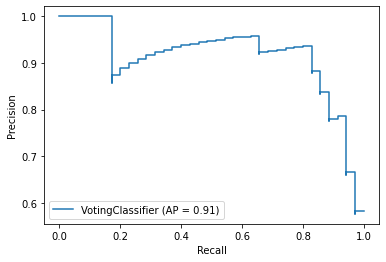

In [43]:
plot_precision_recall_curve(clf_votesoft, X_test, y_test)

This precision-recall curve looks a lot like the linear SVC model's, perhaps suggesting that the linear SVC is making most of the calls in the voting ensemble.

In [16]:
gs_soft = GridSearchCV(clf_votesoft, param_grid, scoring='recall', cv=5)
gs_soft.fit(X_train, y_train)

print(f'Train Recall: {gs_soft.best_score_}')
print(f'Test Recall: {recall_score(y_test, gs_soft.predict(X_test))}')
print(f'Train Accuracy: {accuracy_score(y_train, gs_soft.predict(X_train))}')
print(f'Test Accuracy: {accuracy_score(y_test, gs_soft.predict(X_test))}')
print(gs_soft.best_params_)

Train Recall: 0.7557142857142857
Test Recall: 0.8571428571428571
Train Accuracy: 0.8423423423423423
Test Accuracy: 0.8266666666666667
{'weights': (1, 1, 4)}


In [18]:
confusion_matrix(y_test, gs_soft.predict(X_test))

array([[32,  8],
       [ 5, 30]])